# -----
# FIG 3 in RECCAP SO paper
# -----
# also included: Fig. S7
#
# Plot natural and anthropogenic CO2 fluxes
# 
# Contact: cara.nissen@awi.de or cara.nissen@colorado.edu
#
# version: August 2023
#

In [1]:
### modules
import os
import numpy as np
import seawater as sw
import matplotlib
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from matplotlib import cm 
from datetime import date, timedelta
import copy
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)
from cartopy.util import add_cyclic_point
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
from annualmean import annualmean

In [2]:
#-----
# SETTINGS
# define paths to all data
# define where to save plots (if any)
# define years to average over
#-----

# data sets
path1 = '/pscratch/sd/c/cnissen/RECCAPv2/'
path_models = path1+'reccap_submissions/download_20220124/Models/2D_CO2/' 
path_data   = path1+'reccap_submissions/download_20220124/Surface_CO2/'
path_atminv = path1+'reccap_submissions/download_20220124/Atmospheric_inversions/'
path_soccom = path1+'reccap_submissions/download_20220124/Surface_CO2/'
path_trend  = path1+'reccap_submissions/download_20220124/Models/Linear_trends/' 

# river flux adjustment
path_river  = path1+'masks_reccap/river_flux_adjustment/'

# path to RECCAP SO mask
path_mask = path1+'masks_reccap/'

#----
# specify years to average over
#----
# NOTE: the script is written to plot avrages over 1985-2018 
#    the years are defined here for plot titles and filenames 
year1,year2 = 1985,2018 
eval_time   = np.arange(year1,year2+1) 

#----
# define simulation
#----
sim = 'A'

#----
# define where to save plots
#----
save_to_dir ='/global/cfs/cdirs/m4003/cnissen/Plots/RECCAPv2_SO_Paper/Fig3/'
if not os.path.exists(save_to_dir):
    print ('Created '+save_to_dir)
    os.makedirs(save_to_dir)
    

In [3]:
#------
# define a separate list of models for each of the components to plot
#------
# which models are only availalbe for simA and simB?
# FESOM_HR, MOM6
# which models are only availalbe for simA,simB, and simD?
# ROMS

# variable name of interest
var = '2D_CO2'

models_A  = ('CCSM-WHOI','CESM-ETHZ','CNRM-ESM2-1','EC-Earth3','FESOM_REcoM_HR','FESOM_REcoM_LR',\
             'MOM6-Princeton','MPIOM-HAMOCC','MRI-ESM2-1','NorESM-OC1.2',\
             'ORCA025-GEOMAR','ORCA1-LIM3-PISCES','PlankTOM12','ROMS-SouthernOcean-ETHZ') 
versionID_models_A     = ('20211125','v20211122','v20211208','v20220323','v20211119','v20211119',\
                       'v20220125','v20220110','v20220502','v20211125',\
                       'v20210804','v20211215','v20220404','v20220630') 

models_AD = ('CCSM-WHOI','CESM-ETHZ','CNRM-ESM2-1','EC-Earth3','FESOM_REcoM_LR',\
             'MPIOM-HAMOCC','MRI-ESM2-1','NorESM-OC1.2',\
             'ORCA025-GEOMAR','ORCA1-LIM3-PISCES','PlankTOM12','ROMS-SouthernOcean-ETHZ') 
versionID_models_AD    = ('20211125','v20211122','v20211208','v20220323','v20211119',\
                       'v20220110','v20220502','v20211125',\
                       'v20210804','v20211215','v20220404','v20220630') 

models_AC = ('CCSM-WHOI','CESM-ETHZ','CNRM-ESM2-1','EC-Earth3','FESOM_REcoM_LR',\
             'MPIOM-HAMOCC','MRI-ESM2-1','NorESM-OC1.2',\
             'ORCA025-GEOMAR','ORCA1-LIM3-PISCES','PlankTOM12')
versionID_models_AC    = ('20211125','v20211122','v20211208','v20220323','v20211119',\
                       'v20220110','v20220502','v20211125',\
                       'v20210804','v20211215','v20220404') 

models_CB = ('CCSM-WHOI','CESM-ETHZ','CNRM-ESM2-1','EC-Earth3','FESOM_REcoM_LR',\
             'MPIOM-HAMOCC','MRI-ESM2-1','NorESM-OC1.2',\
             'ORCA025-GEOMAR','ORCA1-LIM3-PISCES','PlankTOM12') 
versionID_models_CB    = ('20211125','v20211122','v20211208','v20220323','v20211119',\
                       'v20220110','v20220502','v20211125',\
                       'v20210804','v20211215','v20220404') 

models_D  = ('CCSM-WHOI','CESM-ETHZ','CNRM-ESM2-1','EC-Earth3','FESOM_REcoM_LR',\
             'MPIOM-HAMOCC','MRI-ESM2-1','NorESM-OC1.2',\
             'ORCA025-GEOMAR','ORCA1-LIM3-PISCES','PlankTOM12','ROMS-SouthernOcean-ETHZ') 
versionID_models_D     = ('20211125','v20211122','v20211208','v20220323','v20211119',\
                       'v20220110','v20220502','v20211125',\
                       'v20210804','v20211215','v20220404','v20220630') 

subregions = ('STSS-Atl','STSS-Ind','STSS-Pac',\
              'SPSS-Atl','SPSS-Ind','SPSS-Pac',\
              'ICE-Atl','ICE-Ind','ICE-Pac','STSS','SPSS','ICE','all')

print ('Models w/ all 4 simulations:',len(models_A),len(versionID_models_A))



Models w/ all 4 simulations: 14 14


In [4]:
#----
# FUNCTIONS
#----

# transform longitude (e.g., go from -179.5:179.5 to 0.5:359.5)
def transform_lon_coord(data):
    # change lon coordinate in 2D array from 0-360 to -180:180
    # for 2D arrays: assume lon coordinate to be the 2nd dimension  
    # for 3D arrays: assume lon coordinate to be the 3rd dimension  
    if len(data.shape)==2:
        data_transformed          = np.empty_like(data)
        data_transformed[:,0:180] = data[:,180:]
        data_transformed[:,180:]  = data[:,0:180] 
    elif len(data.shape)==3:
        data_transformed          = np.empty_like(data)
        try:
            data_transformed[:,:,0:180] = data[:,:,180:]
            data_transformed[:,:,180:]  = data[:,:,0:180]
        except:
            data_transformed[:,0:180,:] = data[:,180:,:]
            data_transformed[:,180:,:]  = data[:,0:180,:] 
    elif len(data.shape)==4:
        data_transformed          = np.empty_like(data)
        data_transformed[:,0:180,:,:] = data[:,180:,:,:]
        data_transformed[:,180:,:,:]  = data[:,0:180,:,:] 
    elif len(data.shape)==1:
        data_transformed          = np.empty_like(data)
        data_transformed[0:180] = data[180:]
        data_transformed[180:]  = data[0:180]
    return data_transformed


In [5]:
#------
# load RECCAP mask for SO
# make sure region mask matches the submitted products in terms of longitude!
#------

# SO RECCAP regions
#reccap_mask_SO   = Dataset(path_mask+'RECCAP2_region_masks_all_v20221025.nc')
#regions          = reccap_mask_SO_2.variables['southern'][:,:] #"1.SO STSS, 2.SO SPSS, 3.SO ICE"
#lon_regions      = reccap_mask_SO_2.variables['lon'][:]
#print(np.min(lon_regions),np.max(lon_regions)) # lon should be from 0-360 (if it is from -180:180, use transform_lon_coord)
#print(np.min(regions_2),np.max(regions_2))

# SO RECCAP regions
reccap_mask_SO = Dataset(path_mask+'reccap_regions_SOsubs.nc')
regions        = reccap_mask_SO.variables['SO_basins_biomes'][:,:]
lon_regions    = reccap_mask_SO.variables['lon'][:]
print(np.min(lon_regions),np.max(lon_regions)) # lon should be from 0-360 (if it is from -180:180, use transform_lon_coord)

# lon in file is -180:180 -> want 0-360, so transform here
regions = transform_lon_coord(regions)
print(np.min(regions),np.max(regions))


-179.5 179.5
0.0 8.0


In [6]:
#-----
# load data
#-----

years_in_file = np.arange(1980,2018+1)

# components to load -> set all to true for Fig. 3 in paper
load_contemp        = True  # simA; "contemporary" (if river flux correction is added)
load_anth           = True  # simA-simD; "anthropogenic"
load_anth_ns_nat_ns = True  # simA-simC; "climate effect"
load_anth_ss        = True  # simC-simB; "CO2 effect"
load_nat            = True  # simD; "natural"

#-----
# models: simA
#-----
if load_contemp:
    flux_models_contemp = np.nan*np.ones([180,360,len(eval_time),len(models_A)])
    for ii in range(0,len(models_A)):
        print ('Load simA of '+models_A[ii])
        ffA = Dataset(path_models+models_A[ii]+'_'+var+'_'+versionID_models_A[ii]+'/'+\
                    'fgco2_'+models_A[ii]+'_A_1_gr_1980-2018_'+versionID_models_A[ii]+'.nc')
        dataA = np.squeeze(ffA.variables['fgco2'][:,:,:])
        dataA = annualmean(dataA)
        if models_A[ii] in ['CCSM-WHOI']: # kick out years 1958-1979
            dataA = -1*dataA[22:,:,:] 
        if models_A[ii] in ['MPIOM-HAMOCC']: # kick out 2019
            dataA = dataA[:-1,:,:]
        try: 
            dataA[dataA.mask==True]=np.nan
        except: 
            pass
        # find position into which to write annual means (depends on years provided in submission)
        if models_A[ii] in ['OCIM-v2014-CTL','CCSM-WHOI']:
            start_ind = np.where(np.asarray(years_in_file)==year1)[0][0]
            end_ind   = np.argmin(np.abs(eval_time-2017)) 
        else:
            start_ind = np.where(np.asarray(years_in_file)==year1)[0][0]
            end_ind   = np.where(np.asarray(years_in_file)==year2)[0][0]
        #print start_ind,end_ind
        dataA = np.transpose(dataA,[1,2,0])
        if models_A[ii] in ['OCIM-v2014-CTL','CCSM-WHOI']:
            flux_models_contemp[:,:,:end_ind+1,ii] = dataA[:,:,start_ind:]
        else: 
            flux_models_contemp[:,:,:,ii] = dataA[:,:,start_ind:end_ind+1]
        #print data.shape
        ffA.close()
        del dataA
        
#-----
# models: simA-simD
#-----
if load_anth:
    flux_models_anth = np.nan*np.ones([180,360,len(eval_time),len(models_AD)])
    for ii in range(0,len(models_AD)):
        print ('Load simA & simD of '+models_AD[ii])
        ffA = Dataset(path_models+models_AD[ii]+'_'+var+'_'+versionID_models_AD[ii]+'/'+\
                    'fgco2_'+models_AD[ii]+'_A_1_gr_1980-2018_'+versionID_models_AD[ii]+'.nc')
        ffD = Dataset(path_models+models_AD[ii]+'_'+var+'_'+versionID_models_AD[ii]+'/'+\
                    'fgco2_'+models_AD[ii]+'_D_1_gr_1980-2018_'+versionID_models_AD[ii]+'.nc')
        dataA = np.squeeze(ffA.variables['fgco2'][:,:,:])
        dataD = np.squeeze(ffD.variables['fgco2'][:,:,:])
        dataA = annualmean(dataA)
        dataD = annualmean(dataD)
        if models_AD[ii] in ['CCSM-WHOI']: # kick out years 1958-1979
            dataA = -1*dataA[22:,:,:] 
            dataD = -1*dataD[22:,:,:] 
        if models_AD[ii] in ['MPIOM-HAMOCC']: # kick out 2019
            dataA = dataA[:-1,:,:]
            dataD = dataD[:-1,:,:]
        try: 
            dataA[dataA.mask==True]=np.nan
            dataD[dataD.mask==True]=np.nan
        except: 
            pass
        # find position into which to write annual means (depends on years provided in submission)
        if models_AD[ii] in ['OCIM-v2014-CTL','CCSM-WHOI']:
            start_ind = np.where(np.asarray(years_in_file)==year1)[0][0]
            end_ind   = np.argmin(np.abs(eval_time-2017)) 
        else:
            start_ind = np.where(np.asarray(years_in_file)==year1)[0][0]
            end_ind   = np.where(np.asarray(years_in_file)==year2)[0][0]
        #print start_ind,end_ind
        
        dataA = np.transpose(dataA,[1,2,0])
        dataD = np.transpose(dataD,[1,2,0])
        if models_AD[ii] in ['OCIM-v2014-CTL','CCSM-WHOI']:
            flux_models_anth[:,:,:end_ind+1,ii] = dataA[:,:,start_ind:]-dataD[:,:,start_ind:]
        else: 
            flux_models_anth[:,:,:,ii] = dataA[:,:,start_ind:end_ind+1]-dataD[:,:,start_ind:end_ind+1]
        #print data.shape
        ffA.close()
        ffD.close()
        del dataA,dataD

#-----
# models: simA-simC
#-----
if load_anth_ns_nat_ns:
    flux_models_anth_ns_nat_ns = np.nan*np.ones([180,360,len(eval_time),len(models_AC)])
    for ii in range(0,len(models_AC)):
        print ('Load simA & simC of '+models_AC[ii])
        ffA = Dataset(path_models+models_AC[ii]+'_'+var+'_'+versionID_models_AC[ii]+'/'+\
                    'fgco2_'+models_AC[ii]+'_A_1_gr_1980-2018_'+versionID_models_AC[ii]+'.nc')
        ffC = Dataset(path_models+models_AC[ii]+'_'+var+'_'+versionID_models_AC[ii]+'/'+\
                    'fgco2_'+models_AC[ii]+'_C_1_gr_1980-2018_'+versionID_models_AC[ii]+'.nc')
        dataA = np.squeeze(ffA.variables['fgco2'][:,:,:])
        dataC = np.squeeze(ffC.variables['fgco2'][:,:,:])
        dataA = annualmean(dataA)
        dataC = annualmean(dataC)
        if models_AC[ii] in ['CCSM-WHOI']: # kick out years 1958-1979
            dataA = -1*dataA[22:,:,:] # flip sign
            dataC = -1*dataC[22:,:,:] # flip sign
        if models_AC[ii] in ['MPIOM-HAMOCC']: # kick out 2019
            dataA = dataA[:-1,:,:]
            dataC = dataC[:-1,:,:]
        try: 
            dataA[dataA.mask==True]=np.nan
            dataC[dataC.mask==True]=np.nan
        except: 
            pass
        
        # find position into which to write annual means (depends on years provided in submission)
        if models_AC[ii] in ['OCIM-v2014-CTL','CCSM-WHOI']:
            start_ind = np.where(np.asarray(years_in_file)==year1)[0][0]
            end_ind   = np.argmin(np.abs(eval_time-2017)) 
        else:
            start_ind = np.where(np.asarray(years_in_file)==year1)[0][0]
            end_ind   = np.where(np.asarray(years_in_file)==year2)[0][0]
        #print start_ind,end_ind
        
        dataA = np.transpose(dataA,[1,2,0])
        dataC = np.transpose(dataC,[1,2,0])
        if models_AC[ii] in ['OCIM-v2014-CTL','CCSM-WHOI']:
            flux_models_anth_ns_nat_ns[:,:,:end_ind+1,ii] = dataA[:,:,start_ind:]-dataC[:,:,start_ind:]
        else: 
            flux_models_anth_ns_nat_ns[:,:,:,ii] = dataA[:,:,start_ind:end_ind+1]-dataC[:,:,start_ind:end_ind+1]
        #print data.shape
        ffA.close()
        ffC.close()
        del dataA,dataC
        
        
#-----
# models: simC-simB
#-----
if load_anth_ss:
    flux_models_anth_ss = np.nan*np.ones([180,360,len(eval_time),len(models_CB)])
    for ii in range(0,len(models_CB)):
        print ('Load simB & simC of '+models_CB[ii])
        ffB = Dataset(path_models+models_CB[ii]+'_'+var+'_'+versionID_models_CB[ii]+'/'+\
                    'fgco2_'+models_CB[ii]+'_B_1_gr_1980-2018_'+versionID_models_CB[ii]+'.nc')
        ffC = Dataset(path_models+models_CB[ii]+'_'+var+'_'+versionID_models_CB[ii]+'/'+\
                    'fgco2_'+models_CB[ii]+'_C_1_gr_1980-2018_'+versionID_models_CB[ii]+'.nc')
        dataB = np.squeeze(ffB.variables['fgco2'][:,:,:])
        dataC = np.squeeze(ffC.variables['fgco2'][:,:,:])
        dataB = annualmean(dataB)
        dataC = annualmean(dataC)
        if models_CB[ii] in ['CCSM-WHOI']: # kick out years 1958-1979
            dataB = -1*dataB[22:,:,:] # flip sign
            dataC = -1*dataC[22:,:,:] # flip sign
        if models_CB[ii] in ['MPIOM-HAMOCC']: # kick out 2019
            dataB = dataB[:-1,:,:]
            dataC = dataC[:-1,:,:]
        try: 
            dataB[dataB.mask==True]=np.nan
            dataC[dataC.mask==True]=np.nan
        except: 
            pass
        
        # find position into which to write annual means (depends on years provided in submission)
        if models_CB[ii] in ['OCIM-v2014-CTL','CCSM-WHOI']:
            start_ind = np.where(np.asarray(years_in_file)==year1)[0][0]
            end_ind   = np.argmin(np.abs(eval_time-2017)) 
        else:
            start_ind = np.where(np.asarray(years_in_file)==year1)[0][0]
            end_ind   = np.where(np.asarray(years_in_file)==year2)[0][0]
        #print start_ind,end_ind
        
        dataB = np.transpose(dataB,[1,2,0])
        dataC = np.transpose(dataC,[1,2,0])
        if models_CB[ii] in ['OCIM-v2014-CTL','CCSM-WHOI']:
            flux_models_anth_ss[:,:,:end_ind+1,ii] = dataC[:,:,start_ind:]-dataB[:,:,start_ind:]
        else: 
            flux_models_anth_ss[:,:,:,ii] = dataC[:,:,start_ind:end_ind+1]-dataB[:,:,start_ind:end_ind+1]
        #print data.shape
        ffB.close()
        ffC.close()
        del dataB,dataC
        
        
#-----
# models: simD
#-----
if load_nat:
    flux_models_nat = np.nan*np.ones([180,360,len(eval_time),len(models_D)])
    for ii in range(0,len(models_D)):
        print ('Load simD of '+models_D[ii])
        ffD = Dataset(path_models+models_D[ii]+'_'+var+'_'+versionID_models_D[ii]+'/'+\
                    'fgco2_'+models_D[ii]+'_D_1_gr_1980-2018_'+versionID_models_D[ii]+'.nc')
        dataD = np.squeeze(ffD.variables['fgco2'][:,:,:])
        dataD = annualmean(dataD)
        if models_D[ii] in ['CCSM-WHOI']: # kick out years 1958-1979
            dataD = -1*dataD[22:,:,:] # flip sign
        if models_D[ii] in ['MPIOM-HAMOCC']: # kick out 2019
            dataD = dataD[:-1,:,:]
        try: 
            dataD[dataD.mask==True]=np.nan
        except: 
            pass
        
        # find position into which to write annual means (depends on years provided in submission)
        if models_D[ii] in ['OCIM-v2014-CTL','CCSM-WHOI']:
            start_ind = np.where(np.asarray(years_in_file)==year1)[0][0]
            end_ind   = np.argmin(np.abs(eval_time-2017)) 
        else:
            start_ind = np.where(np.asarray(years_in_file)==year1)[0][0]
            end_ind   = np.where(np.asarray(years_in_file)==year2)[0][0]
        #print start_ind,end_ind
        
        dataD = np.transpose(dataD,[1,2,0])
        if models_D[ii] in ['OCIM-v2014-CTL','CCSM-WHOI']:
            flux_models_nat[:,:,:end_ind+1,ii] = dataD[:,:,start_ind:]
        else: 
            flux_models_nat[:,:,:,ii] = dataD[:,:,start_ind:end_ind+1]
        #print data.shape
        ffD.close()
        del dataD
        
print ('done')


Load simA of CCSM-WHOI
Load simA of CESM-ETHZ
Load simA of CNRM-ESM2-1
Load simA of EC-Earth3
Load simA of FESOM_REcoM_HR


/global/u2/c/cnissen/scripts_reccap/annualmean.py:43: RuntimeWarning: Mean of empty slice
  var_annualmean[t,:,:] = np.nanmean(datamB, axis=0)


Load simA of FESOM_REcoM_LR
Load simA of MOM6-Princeton
Load simA of MPIOM-HAMOCC
Load simA of MRI-ESM2-1
Load simA of NorESM-OC1.2
Load simA of ORCA025-GEOMAR
Load simA of ORCA1-LIM3-PISCES
Load simA of PlankTOM12
Load simA of ROMS-SouthernOcean-ETHZ
Load simA & simD of CCSM-WHOI
Load simA & simD of CESM-ETHZ
Load simA & simD of CNRM-ESM2-1
Load simA & simD of EC-Earth3
Load simA & simD of FESOM_REcoM_LR
Load simA & simD of MPIOM-HAMOCC
Load simA & simD of MRI-ESM2-1
Load simA & simD of NorESM-OC1.2
Load simA & simD of ORCA025-GEOMAR
Load simA & simD of ORCA1-LIM3-PISCES
Load simA & simD of PlankTOM12
Load simA & simD of ROMS-SouthernOcean-ETHZ
Load simA & simC of CCSM-WHOI
Load simA & simC of CESM-ETHZ
Load simA & simC of CNRM-ESM2-1
Load simA & simC of EC-Earth3
Load simA & simC of FESOM_REcoM_LR
Load simA & simC of MPIOM-HAMOCC
Load simA & simC of MRI-ESM2-1
Load simA & simC of NorESM-OC1.2
Load simA & simC of ORCA025-GEOMAR
Load simA & simC of ORCA1-LIM3-PISCES
Load simA & simC of

In [7]:
#---
# print some numbers (to spot any obvious problems)
#---

if load_contemp:
    print ('-----')
    print ('contemp,all')
    print ('-----')
    for ii in range(0,len(models_A)):
        print (models_A[ii]+': '+str(np.nanmin(flux_models_contemp[:,:,:,ii]))+' '+\
                str(np.nanmax(flux_models_contemp[:,:,:,ii])))

if load_anth:
    print ('-----')
    print ('anth,all')
    print ('-----')
    for ii in range(0,len(models_AD)):
        print (models_AD[ii]+': '+str(np.nanmin(flux_models_anth[:,:,:,ii]))+' '+\
                str(np.nanmax(flux_models_anth[:,:,:,ii])))

if load_anth_ns_nat_ns:
    print ('-----')
    print ('anth,ns + natural,ns')
    print ('-----')
    for ii in range(0,len(models_AC)):
        print (models_AC[ii]+': '+str(np.nanmin(flux_models_anth_ns_nat_ns[:,:,:,ii]))+' '+\
                str(np.nanmax(flux_models_anth_ns_nat_ns[:,:,:,ii])))
            
if load_anth_ss:
    print ('-----')
    print ('anth,ss')
    print ('-----')
    for ii in range(0,len(models_CB)):
        print (models_CB[ii]+': '+str(np.nanmin(flux_models_anth_ss[:,:,:,ii]))+' '+\
                str(np.nanmax(flux_models_anth_ss[:,:,:,ii])))
            
            
if load_nat:
    print ('-----')
    print ('nat')
    print ('-----')
    for ii in range(0,len(models_D)):
        print (models_D[ii]+': '+str(np.nanmin(flux_models_nat[:,:,:,ii]))+' '+\
                str(np.nanmax(flux_models_nat[:,:,:,ii])))
            

-----
contemp,all
-----
CCSM-WHOI: -3.328032391891611e-07 2.3799766779575293e-07
CESM-ETHZ: -1.8722379024893598e-07 1.8758713338229427e-07
CNRM-ESM2-1: -3.473808677055083e-07 7.243008834001572e-07
EC-Earth3: -3.455088517512195e-07 2.9743890195277345e-07
FESOM_REcoM_HR: -1.0287609477898954e-06 3.291037252258339e-07
FESOM_REcoM_LR: -5.16851747625652e-07 3.551971909955131e-07
MOM6-Princeton: -6.316397609341927e-07 8.285434885537167e-07
MPIOM-HAMOCC: -2.1326543730992853e-07 2.601472033347818e-07
MRI-ESM2-1: -6.728191124238947e-07 2.867927548777516e-07
NorESM-OC1.2: -3.108359862835641e-07 3.516230151490163e-07
ORCA025-GEOMAR: -5.994956284336938e-07 3.7668123493913067e-07
ORCA1-LIM3-PISCES: -4.1642874748504255e-07 2.7747370268116356e-07
PlankTOM12: -4.364177641491551e-07 1.7493054826900334e-07
ROMS-SouthernOcean-ETHZ: -2.626861999033281e-07 4.0850900973055104e-07
-----
anth,all
-----
CCSM-WHOI: -3.209891374922336e-08 1.0077427248234017e-07
CESM-ETHZ: -2.1044527898084198e-08 1.059506491429829

In [8]:
#------
# get surface area of all the biomes
#------
# calculate area with sw.dist

def get_areas_biomes(area,regions,subregions):
    # calculate area-weighted averages of a given quantity in data according to biomes defined
    # after Fay & McKinley (2014), use RECCAP mask loaded further up
    # provide "area" (with lon from 0:360)
    
    # only consider area for SO RECCAP mask
    area[regions.mask==True]=0
    print ('Total Southern Ocean ocean surface area '+str(np.nansum(area))+' m2')
    
    data_avg = np.zeros(13) # 9 regions in SO, + 3 for combined sectors, +1 for whole SO
    for i in range(0,13):
        reg2  = regions.ravel()
        area2 = area.ravel()
        if subregions[i] in ['STSS-Atl']:
            ind_region = np.where(reg2==0)[0]
        elif subregions[i] in ['STSS-Ind']:
            ind_region = np.where(reg2==3)[0]
        elif subregions[i] in ['STSS-Pac']:
            ind_region = np.where(reg2==6)[0]
        elif subregions[i] in ['SPSS-Atl']:
            ind_region = np.where(reg2==1)[0]
        elif subregions[i] in ['SPSS-Ind']:
            ind_region = np.where(reg2==4)[0]
        elif subregions[i] in ['SPSS-Pac']:
            ind_region = np.where(reg2==7)[0]
        elif subregions[i] in ['ICE-Atl']:
            ind_region = np.where(reg2==2)[0]
        elif subregions[i] in ['ICE-Ind']:
            ind_region = np.where(reg2==5)[0]
        elif subregions[i] in ['ICE-Pac']:
            ind_region = np.where(reg2==8)[0]
        elif subregions[i] in ['STSS']:
            ind_region = np.where((reg2==0) | (reg2==3) | (reg2==6))[0]
        elif subregions[i] in ['SPSS']:
            ind_region = np.where((reg2==1) | (reg2==4) | (reg2==7))[0]
        elif subregions[i] in ['ICE']:
            ind_region =np.where((reg2==2) | (reg2==5) | (reg2==8))[0]
        elif subregions[i] in ['all']:
            ind_region = np.where(reg2>=0)[0]
        data_avg[i] = np.nansum(area2[ind_region]) #np.nansum(data2[ind_region]*area2[ind_region]/total_area)
        del reg2, area2,ind_region
    return data_avg

# define for filtering, but don't use for area calculation
lon = np.arange(0.5,359.5+1,1)
lat = np.arange(-89.5,89.5+1,1)

# need the box boundaries for area calculation
xi = np.arange(0,360+1,1)
yi = np.arange(-90,90+1,1) 

area = np.zeros((len(xi)-1,len(yi)-1))
#calculate area
for i in range(0,len(xi)-1): #laenge pruefen!
    if i==np.round(len(xi)/2): 
        print ('50% done')
    for j in range(0,len(yi)-1): 
        dist1 = sw.dist([yi[j],yi[j+1]],[xi[i],xi[i]])
        dist2 = sw.dist([yi[j],yi[j]],[xi[i],xi[i+1]])
        area[i][j] = float(dist1[0]) * float(dist2[0]) *1000 *1000 #m2
area = area.transpose()
print ('Global area:',np.sum(area),'m2') 
area_global = np.copy(area)

area_biomes = get_areas_biomes(area,regions,subregions)

#print (area_biomes)
print('TEST: the following three should be identical')
print (np.sum(area_biomes[0:9])) # 9 subregions
print (np.sum(area_biomes[9:12])) # 3 subregions
print (np.sum(area_biomes[12])) # 1 subregion 


50% done
Global area: 509364377985322.94 m2
Total Southern Ocean ocean surface area 77409028462219.4 m2
TEST: the following three should be identical
77409028462219.4
77409028462219.42
77409028462219.42


In [9]:
#-----
# get subareas avg
#-----

def get_subarea_avg(flux_models,regions,area,eval_time,models_ABCD,subregions):
    flux_subareas  = np.nan*np.ones([len(eval_time),len(models_ABCD),len(subregions)])
    biome_areas    = np.nan*np.ones([len(models_ABCD),len(subregions)]) 
    for pp in range(0,len(models_ABCD)):
        counter=0 # only for printing of total area
        print ('Process '+models_ABCD[pp])
        for i in range(0,len(subregions)):
            for yy in range(0,len(eval_time)):
                data1 = flux_models[:,:,yy,pp]
                reg2  = regions.ravel()  # SO RECCAP mask
                area2 = area.ravel() # surface area
                data2 = data1.ravel()
                if subregions[i] in ['STSS-Atl']:
                    ind_region = np.where(reg2==0)[0]
                elif subregions[i] in ['STSS-Ind']:
                    ind_region = np.where(reg2==3)[0]
                elif subregions[i] in ['STSS-Pac']:
                    ind_region = np.where(reg2==6)[0]
                elif subregions[i] in ['SPSS-Atl']:
                    ind_region = np.where(reg2==1)[0]
                elif subregions[i] in ['SPSS-Ind']:
                    ind_region = np.where(reg2==4)[0]
                elif subregions[i] in ['SPSS-Pac']:
                    ind_region = np.where(reg2==7)[0]
                elif subregions[i] in ['ICE-Atl']:
                    ind_region = np.where(reg2==2)[0]
                elif subregions[i] in ['ICE-Ind']:
                    ind_region = np.where(reg2==5)[0]
                elif subregions[i] in ['ICE-Pac']:
                    ind_region = np.where(reg2==8)[0]
                elif subregions[i] in ['STSS']:
                    ind_region = np.where((reg2==0) | (reg2==3) | (reg2==6))[0]
                elif subregions[i] in ['SPSS']:
                    ind_region = np.where((reg2==1) | (reg2==4) | (reg2==7))[0]
                elif subregions[i] in ['ICE']:
                    ind_region =np.where((reg2==2) | (reg2==5) | (reg2==8))[0]
                elif subregions[i] in ['all']:
                    ind_region = np.where(reg2>=0)[0]
                    
                ind_not_nan_data = np.where(~np.isnan(data2[ind_region]))[0] # only consider data points that are filled
                total_area = np.sum(area2[ind_region][ind_not_nan_data])
                #total_area = np.sum(area2[ind_region])
                if np.nansum(data1)!=0: # only for years which are filled
                    if (subregions[i] in ['all']) & (counter==0):
                        print (total_area) 
                        counter = 1
                    biome_areas[pp,i] = total_area 
                    flux_subareas[yy,pp,i] = np.nansum(data2[ind_region]*area2[ind_region]/total_area)   
                #total_area = np.sum(area2[ind_region])
                #if np.nansum(data1)!=0: # only for years which are filled
                #    flux_subareas[yy,pp,i] = np.nansum(data2[ind_region]*area2[ind_region]/total_area)
                del data1,reg2,area2,data2,ind_region,total_area
    return flux_subareas,biome_areas
    

In [10]:
#------
# get subarea mean of different components
#------

# calculate subarea averages
#subregions = ('STSS_Atl','SPSS_Atl','ICE_Atl','STSS_Ind','SPSS_Ind',\
#              'ICE_Ind','STSS_Pac','SPSS_Pac','ICE_Pac','STSS','SPSS','ICE')#,'all')
# 13 regions: 9 regions in SO, + 3 for combined sectors, +1 for whole SO

#load_contemp        = True  # simA; "contemporary" (if river flux correction is added)
#load_anth           = True  # simA-simD; "anthropogenic"
#load_anth_ns_nat_ns = True  # simA-simC; "climate effect"
#load_anth_ss        = True  # simC-simB; "CO2 effect"
#load_nat            = True  # simD; "natural"

if load_contemp:
    #------
    # models
    #------
    print ('-----')
    print ('contemporary,all')
    print ('-----')
    flux_models_contemp_subareas,biome_area_models_A = get_subarea_avg(flux_models_contemp,regions,area,\
                                                eval_time,models_A,subregions)


if load_anth:
    #------
    # models
    #------
    print ('-----')
    print ('anth,all')
    print ('-----')
    flux_models_anth_subareas,biome_area_models_AD = get_subarea_avg(flux_models_anth,regions,area,\
                                                eval_time,models_AD,subregions)

if load_anth_ns_nat_ns:
    #------
    # models
    #------
    print ('-----')
    print ('anth,ns + natural,ns')
    print ('-----')
    flux_models_anth_ns_nat_ns_subareas,biome_area_models_AC = get_subarea_avg(flux_models_anth_ns_nat_ns,regions,area,\
                                                      eval_time,models_AC,subregions)
                
if load_anth_ss:
    #------
    # models
    #------
    print ('-----')
    print ('anth,ss')
    print ('-----')
    flux_models_anth_ss_subareas,biome_area_models_CB = get_subarea_avg(flux_models_anth_ss,regions,area,\
                                                      eval_time,models_CB,subregions)
                    
if load_nat:
    #------
    # models
    #------
    print ('-----')
    print ('nat')
    print ('-----')
    flux_models_nat_subareas,biome_area_models_D = get_subarea_avg(flux_models_nat,regions,area,\
                                                      eval_time,models_D,subregions)
    
    

-----
contemporary,all
-----
Process CCSM-WHOI
74492275264407.1
Process CESM-ETHZ
76149904481959.67
Process CNRM-ESM2-1
77371852756049.22
Process EC-Earth3
77409028462219.42
Process FESOM_REcoM_HR
77075005194060.84
Process FESOM_REcoM_LR
77075005194060.84
Process MOM6-Princeton
77075005194060.84
Process MPIOM-HAMOCC
76003285884316.31
Process MRI-ESM2-1
77325948214566.8
Process NorESM-OC1.2
77374505093557.94
Process ORCA025-GEOMAR
77289199561810.75
Process ORCA1-LIM3-PISCES
77402636845977.3
Process PlankTOM12
76670454088793.06
Process ROMS-SouthernOcean-ETHZ
76894536194319.66
-----
anth,all
-----
Process CCSM-WHOI
74492275264407.1
Process CESM-ETHZ
76149904481959.67
Process CNRM-ESM2-1
77371852756049.22
Process EC-Earth3
77409028462219.42
Process FESOM_REcoM_LR
77075005194060.84
Process MPIOM-HAMOCC
76003285884316.31
Process MRI-ESM2-1
77325948214566.8
Process NorESM-OC1.2
77374505093557.94
Process ORCA025-GEOMAR
77289199561810.75
Process ORCA1-LIM3-PISCES
77402636845977.3
Process Plank

In [11]:
#---
# print some more numbers
#----

ss = -1

#load_contemp        = True  # simA; "contemporary" (if river flux correction is added)
#load_anth           = True  # simA-simD; "anthropogenic"
#load_anth_ns_nat_ns = True  # simA-simC; "climate effect"
#load_anth_ss        = True  # simC-simB; "CO2 effect"
#load_nat            = True  # simD; "natural"

print ('######')
print ('Subregion '+subregions[ss]+':')
print ('######')
if load_contemp:
    print ('-----')
    print ('contemporary,all')
    print ('-----')
    for ii in range(0,len(models_A)):
        if models_A[ii] in ['OCIM-v2014-CTL','CCSM-WHOI']: # year 2018 not available!, print year 2017!
             print (models_A[ii]+': '+str(flux_models_contemp_subareas[-2,ii,ss])) # last year, whole SO 
        else:
            print (models_A[ii]+': '+str(flux_models_contemp_subareas[-1,ii,ss])) # last year, whole SO 
            
if load_anth:
    print ('-----')
    print ('anth,all')
    print ('-----')
    for ii in range(0,len(models_AD)):
        if models_AD[ii] in ['OCIM-v2014-CTL','CCSM-WHOI']: # year 2018 not available!, print year 2017!
             print (models_AD[ii]+': '+str(flux_models_anth_subareas[-2,ii,ss])) # last year, whole SO 
        else:
            print (models_AD[ii]+': '+str(flux_models_anth_subareas[-1,ii,ss])) # last year, whole SO 
            
if load_anth_ns_nat_ns:
    print ('-----')
    print ('anth,ns + natural,ns')
    print ('-----')
    for ii in range(0,len(models_AC)):
        if models_AC[ii] in ['OCIM-v2014-CTL','CCSM-WHOI']: # year 2018 not available!, print year 2017!
             print (models_AC[ii]+': '+str(flux_models_anth_ns_nat_ns_subareas[-2,ii,ss])) # last year, whole SO 
        else:
            print (models_AC[ii]+': '+str(flux_models_anth_ns_nat_ns_subareas[-1,ii,ss])) # last year, whole SO 
            
if load_anth_ss:
    print ('-----')
    print ('anth,ss')
    print ('-----')
    for ii in range(0,len(models_CB)):
        if models_CB[ii] in ['OCIM-v2014-CTL','CCSM-WHOI']: # year 2018 not available!, print year 2017!
             print (models_CB[ii]+': '+str(flux_models_anth_ss_subareas[-2,ii,ss])) # last year, whole SO 
        else:
            print (models_CB[ii]+': '+str(flux_models_anth_ss_subareas[-1,ii,ss])) # last year, whole SO 
            
if load_nat:
    print ('-----')
    print ('nat')
    print ('-----')
    for ii in range(0,len(models_D)):
        if models_D[ii] in ['OCIM-v2014-CTL','CCSM-WHOI']: # year 2018 not available!, print year 2017!
             print (models_D[ii]+': '+str(flux_models_nat_subareas[-2,ii,ss])) # last year, whole SO 
        else:
            print (models_D[ii]+': '+str(flux_models_nat_subareas[-1,ii,ss])) # last year, whole SO 
            

######
Subregion all:
######
-----
contemporary,all
-----
CCSM-WHOI: 2.035881093091796e-08
CESM-ETHZ: 3.120886545477298e-08
CNRM-ESM2-1: 1.842900355708883e-08
EC-Earth3: 1.598884661619452e-08
FESOM_REcoM_HR: 4.683412766973994e-08
FESOM_REcoM_LR: 3.871533671451623e-08
MOM6-Princeton: 3.9561852176573295e-08
MPIOM-HAMOCC: 4.1949297658834164e-08
MRI-ESM2-1: 3.443743117206353e-08
NorESM-OC1.2: 4.3581461856629926e-08
ORCA025-GEOMAR: 4.581613858215737e-08
ORCA1-LIM3-PISCES: 2.985258511197887e-08
PlankTOM12: 2.95879817034716e-08
ROMS-SouthernOcean-ETHZ: 3.5841547686978557e-08
-----
anth,all
-----
CCSM-WHOI: 2.6379242697208408e-08
CESM-ETHZ: 3.297983775166009e-08
CNRM-ESM2-1: 3.42254411797309e-08
EC-Earth3: 3.4572256028658694e-08
FESOM_REcoM_LR: 3.2284932531632916e-08
MPIOM-HAMOCC: 4.4802696036686105e-08
MRI-ESM2-1: 4.176587150946335e-08
NorESM-OC1.2: 3.8714882501739366e-08
ORCA025-GEOMAR: 3.548657577783982e-08
ORCA1-LIM3-PISCES: 3.194343783581664e-08
PlankTOM12: 4.321429786896129e-08
ROMS-Sout

In [12]:
#-----
# get multi-model and multi-data mean
#-----

# average over all years
if load_contemp:
    flux_models_contemp_subareas        = np.nanmean(flux_models_contemp_subareas,axis=0)
if load_anth:
    flux_models_anth_subareas           = np.nanmean(flux_models_anth_subareas,axis=0)
if load_anth_ns_nat_ns: 
    flux_models_anth_ns_nat_ns_subareas = np.nanmean(flux_models_anth_ns_nat_ns_subareas,axis=0)
if load_anth_ss:
    flux_models_anth_ss_subareas        = np.nanmean(flux_models_anth_ss_subareas,axis=0)
if load_nat:
    flux_models_nat_subareas            = np.nanmean(flux_models_nat_subareas,axis=0)

if load_contemp:
    multi_model_mean_contemp           = np.nanmean(flux_models_contemp_subareas,axis=0)
    multi_model_std_contemp            = np.nanstd(flux_models_contemp_subareas,axis=0)
if load_anth:
    multi_model_mean_anth           = np.nanmean(flux_models_anth_subareas,axis=0)
    multi_model_std_anth            = np.nanstd(flux_models_anth_subareas,axis=0)
if load_anth_ns_nat_ns: 
    multi_model_mean_anth_ns_nat_ns = np.nanmean(flux_models_anth_ns_nat_ns_subareas,axis=0)
    multi_model_std_anth_ns_nat_ns  = np.nanstd(flux_models_anth_ns_nat_ns_subareas,axis=0)
if load_anth_ss:
    multi_model_mean_anth_ss        = np.nanmean(flux_models_anth_ss_subareas,axis=0)
    multi_model_std_anth_ss         = np.nanstd(flux_models_anth_ss_subareas,axis=0)
if load_nat:
    multi_model_mean_nat            = np.nanmean(flux_models_nat_subareas,axis=0)
    multi_model_std_nat             = np.nanstd(flux_models_nat_subareas,axis=0)
    

In [13]:
#----
# get subarea avg for river flux field (less dimensions)
#----

def get_ind_subarea(reg2,subarea):
    if subarea in ['STSS-Atl']:
        ind_region = np.where(reg2==0)[0]
    elif subarea in ['STSS-Ind']:
        ind_region = np.where(reg2==3)[0]
    elif subarea in ['STSS-Pac']:
        ind_region = np.where(reg2==6)[0]
    elif subarea in ['SPSS-Atl']:
        ind_region = np.where(reg2==1)[0]
    elif subarea in ['SPSS-Ind']:
        ind_region = np.where(reg2==4)[0]
    elif subarea in ['SPSS-Pac']:
        ind_region = np.where(reg2==7)[0]
    elif subarea in ['ICE-Atl']:
        ind_region = np.where(reg2==2)[0]
    elif subarea in ['ICE-Ind']:
        ind_region = np.where(reg2==5)[0]
    elif subarea in ['ICE-Pac']:
        ind_region = np.where(reg2==8)[0]
    elif subarea in ['STSS']:
        ind_region = np.where((reg2==0) | (reg2==3) | (reg2==6))[0]
    elif subarea in ['SPSS']:
        ind_region = np.where((reg2==1) | (reg2==4) | (reg2==7))[0]
    elif subarea in ['ICE']:
        ind_region =np.where((reg2==2) | (reg2==5) | (reg2==8))[0]
    elif subarea in ['all']:
        ind_region = np.where(reg2>=0)[0]
    return ind_region

def get_subarea_avg_river(flux_models,regions,area,eval_time,models_ABCD,subregions):
    #print flux_models.shape
    flux_subareas  = np.nan*np.ones([len(models_ABCD),len(subregions)]) 
    biome_areas    = np.nan*np.ones([len(models_ABCD),len(subregions)]) 
    for pp in range(0,len(models_ABCD)):
        counter=0 # only for printing of total area
        print ('Process '+models_ABCD[pp])
        for i in range(0,len(subregions)):
            data1 = flux_models[:,:]
            reg2  = regions.ravel()  # SO RECCAP mask
            area2 = area.ravel() # surface area
            data2 = data1.ravel()
                
            ind_region = get_ind_subarea(reg2,subregions[i])
                    
            ind_not_nan_data = np.where(~np.isnan(data2[ind_region]))[0] # only consider data points that are filled
            total_area = np.sum(area2[ind_region][ind_not_nan_data])
            #total_area = np.sum(area2[ind_region])
            if np.nansum(data1)!=0: # only for years which are filled
                if (subregions[i] in ['all']) & (counter==0):
                    print (total_area )
                    counter = 1
                biome_areas[pp,i] = total_area 
                flux_subareas[pp,i] = np.nansum(data2[ind_region]*area2[ind_region]/total_area)
            del data1,reg2,area2,data2,ind_region,total_area
    return flux_subareas,biome_areas


In [14]:
#----
# load river file
#----
# if true, the flux is added to the models

river_adjustment = True
if river_adjustment: 
    river_adj_names = ('Lacroix2020')
    ff = Dataset(path_river+'fgco2_lacroix-river_v20211223.nc')
    river = ff.variables['fgco2'][:] # lon is 0-360, needs to be transformed for plotting
    ff.close()
    print (river.shape)
    
if river_adjustment:
    print ('-----')
    print ('river flux')
    print ('-----')
    river_subareas,biome_area_river = get_subarea_avg_river(river,regions,area,\
                                                eval_time,[river_adj_names],subregions)
    river_subareas = np.squeeze(river_subareas)
    biome_area_river = np.squeeze(biome_area_river )
    
ss = -1

print ('######')
print ('Subregion '+subregions[ss]+':')
print ('######')
if river_adjustment:
    print ('River adjustment: '+str(river_subareas[ss]) )

if river_adjustment:
    add_to_models = np.copy(river_subareas)
else:
    add_to_models = np.zeros_like(river_subareas) # add a field of zeros
print ('River fluxes to add for subregion all:',add_to_models[-1])


#----
# check for river fluxes
#----
if river_adjustment:
    print ('')
    print ('River flux adjustment (pos=outgassing):')
    factor = 365.*86400.*12.011/1e15 # don't use "-1" here; global number should positive = outgassing due to rivers
    for ss in range(0,len(subregions)):
        print (subregions[ss]+': '+str(factor*river_subareas[ss]*biome_area_river[ss])+' Pg C yr-1')
    # check: add up 3 subregions
    print ('based on STSS/SPSS/ICE: '+str(np.sum(factor*river_subareas[9:12]*biome_area_river[9:12]))+' Pg C yr-1')

    print ('Global ocean area: '+str(np.sum(area_global))+' m2')
    print ('Global river flux: '+str(np.nansum(factor*np.multiply(river,area_global)))+' Pg C yr-1')
    print ('SO/Global: '+str(100*factor*river_subareas[-1]*biome_area_river[-1]/np.nansum(factor*np.multiply(river,area_global)))+'%')
    print ('')
    #print river




(180, 360)
-----
river flux
-----
Process Lacroix2020
76118473462222.84
######
Subregion all:
######
River adjustment: 1.3662420531327198e-09
River fluxes to add for subregion all: 1.3662420531327198e-09

River flux adjustment (pos=outgassing):
STSS-Atl: -0.015457404851991109 Pg C yr-1
STSS-Ind: 0.002634900538032522 Pg C yr-1
STSS-Pac: -0.0013746296628875535 Pg C yr-1
SPSS-Atl: -0.008256681931823339 Pg C yr-1
SPSS-Ind: 0.04522614246161138 Pg C yr-1
SPSS-Pac: 0.016259847673119988 Pg C yr-1
ICE-Atl: -0.003563709029513133 Pg C yr-1
ICE-Ind: 0.005494486896387393 Pg C yr-1
ICE-Pac: -0.0015713637448979212 Pg C yr-1
STSS: -0.014197133976846134 Pg C yr-1
SPSS: 0.05322930820290803 Pg C yr-1
ICE: 0.00035941412197633687 Pg C yr-1
all: 0.03939158834803824 Pg C yr-1
based on STSS/SPSS/ICE: 0.03939158834803823 Pg C yr-1
Global ocean area: 509364377985322.94 m2
Global river flux: 0.6154180325426 Pg C yr-1
SO/Global: 6.400785525456878%



Index of FESOM_HR: 4
Index of MOM6: 6
All inidces except those two: [0, 1, 2, 3, 5, 7, 8, 9, 10, 11, 12, 13]
######
Contemporary flux in all
######

Check numbers:
mean as plotted: -0.7027541485850782
mean with all models: -0.7468782248467589

river flux: 0.039391588348038235
Multi-model mean: -0.7027541485850782
CCSM-WHOI -0.3549214648112905
CESM-ETHZ -0.7070195291263254
CNRM-ESM2-1 -0.31540762425052316
EC-Earth3 -0.2279300038938462
FESOM_REcoM_HR -1.0723580420790226
FESOM_REcoM_LR -0.8868646428034554
MOM6-Princeton -0.9508873227546627
MPIOM-HAMOCC -0.9912763060431262
MRI-ESM2-1 -0.7045457122973873
NorESM-OC1.2 -1.1158766768676394
ORCA025-GEOMAR -1.0933274493047078
ORCA1-LIM3-PISCES -0.7150844901258481
PlankTOM12 -0.6374964832226601
ROMS-SouthernOcean-ETHZ -0.6832994002741305
avg natural: 0.04846328402858143
avg anthropogenic: -0.790609020961698
CHECK nat+anth+riv (should be equal to multi-model mean): -0.7027541485850783

all, avg climate effect: 0.04455532281130001
ICE, avg climate 

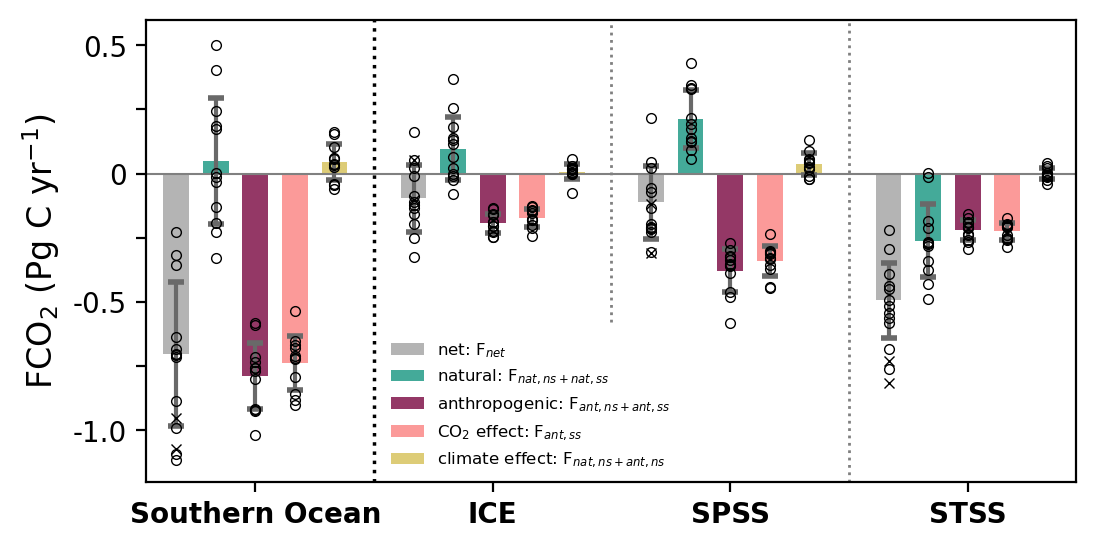

In [22]:
#----
# plot
#----

# for consistency, take FESOM_HR and MOM6 out of the mean contemporary bar
# like that, contemporary = natural + anth + rivers
# if I don't exclude these two, the set of models considered for contemp is different from that for nat and anth
# use a different symbol for these two models
ind_fesom_hr = models_A.index("FESOM_REcoM_HR")
print ('Index of FESOM_HR:',ind_fesom_hr)
ind_mom6 = models_A.index("MOM6-Princeton")
print ('Index of MOM6:',ind_mom6)
ind_not_those = []
for i, elem in enumerate(models_A):
    if 'FESOM_REcoM_HR' not in elem:
        if 'MOM6-Princeton' not in elem:
            ind_not_those.append(i)
print ('All inidces except those two:',ind_not_those)

factor2 = -1*365.*86400.*12.011/1e15
factor  = 365.*86400.*12.011/1e15 # for river fluxes

width = 0.65
shift = 0.2
fs_text = 12
dpicnt  =200

color1 = (180./255.,180./255.,180./255.) # contemporary, grey
color2 = (68./255.,170./255.,153./255.) # natural, teal
color3 = (136./255.,34./255.,85./255.) #(205./255.,92./255.,92./255.) # anthropogenic, dark red
color4 = (251./255.,154./255.,153./255.) #(204./255.,102./255.,119./255.) # CO2 effect, light red
color5 = (221./255.,204./255.,119./255.) # climate effect, sand
    
#color1 = (31./255.,120./255.,180./255.) # contemporary, blue
#color2 = (51./255.,160./255.,44./255.) # natural, dark green
#color3 = (165./255.,42./255.,42./255.) #(205./255.,92./255.,92./255.) # anthropogenic, dark red
#color4 = (251./255.,154./255.,153./255.) # CO2 effect, light red
#color5 = (178./255.,223./255.,138./255.) # climate effect, light green
    
#color1 = (251./255.,154./255.,153./255.) # contemporary, light red
#color2 = (31./255.,120./255.,180./255.) # natural, dark blue
#color3 = (51./255.,160./255.,44./255.) # anthropogenic, dark green
#color4 = (178./255.,223./255.,138./255.) # CO2 effect, light green
#color5 = (166./255.,206./255.,227./255.) # climate effect, light blue

alpha_contemp = 1.0
alpha_nat     = 1.0#0.8
alpha_anth    = 0.9#1.0#0.6
alpha_co2     = 1.0#0.4
alpha_clim    = 1.0#0.2

#natural = '#1f78b4',  # dark blue
#climate_effect = '#a6cee3',  # light blue
#co2_effect = '#b2df8a',  # light green
#anthropogenic = '#33a02c',  # dark green
#contemporary = '#fb9a99' # light red/pink

#166,206,227 # light blue
#31,120,180 # dark blue
#178,223,138 # light green
#51,160,44 # dark green
#251,154,153 # light red

color_dots = 'black'
# markers for each model/data product
circle_size=3.5
edgewidth=0.5
# whiskers for model/data spread
whisker_properties = dict(lw=1.5, capsize=3, capthick=2,ecolor='dimgrey')

panel_label = ''
unit = 'FCO$_{2}$ (Pg C yr$^{-1}$)'

ind_ss1 = -1
ind_ss2 = -2
ind_ss3 = -3
ind_ss4 = -4

x_pos =np.asarray([1,2,3,4,5,\
        7,8,9,10,11,\
        13,14,15,16,17,\
        19,20,21,22,23])
x_pos = np.reshape(x_pos,[4,5])

check_numbers = True # option to print some numbers

label1 = 'net: F$_{net}$' #'contemporary FCO$_{2}$'
label2 = 'natural: F$_{nat,ns+nat,ss}$' #'natural FCO$_{2}$'
label3 = 'anthropogenic: F$_{ant,ns+ant,ss}$' #'anthropogenic FCO$_{2}$'
label4 = 'CO$_{2}$ effect: F$_{ant,ss}$' #'CO2 effect on FCO$_{2}$'
label5 = 'climate effect: F$_{nat,ns+ant,ns}$' #'climate effect on total FCO$_{2}$'

fig, axs = plt.subplots(1,1,figsize=(6,3), dpi=dpicnt,\
                            gridspec_kw={'width_ratios': [1],\
                                         'height_ratios': [1]})

ax1 = plt.subplot2grid((1,1), (0,0))#, colspan=6)

ax=ax1
ax.hlines(0,np.min(x_pos)-0.75,np.max(x_pos)+0.75,color='grey',linewidth=0.75)

#-----
# subregion: all
#-----
rr=ind_ss1
col=0
if check_numbers:
    print ('######')
    print ('Contemporary flux in',subregions[rr])
    print ('######')
# contemporary
alpha1 = alpha_contemp
riv = factor*biome_area_river[rr]*add_to_models[rr]
print()
print('Check numbers:')
print('mean as plotted:',np.mean(factor2*biome_area_models_A[ind_not_those,rr]*flux_models_contemp_subareas[ind_not_those,rr]+riv,axis=0))
print('mean with all models:',np.mean(factor2*biome_area_models_A[:,rr]*flux_models_contemp_subareas[:,rr]+riv,axis=0))
print()
m_mean = np.mean(factor2*biome_area_models_A[ind_not_those,rr]*flux_models_contemp_subareas[ind_not_those,rr]+riv,axis=0)
m_std  = np.std(factor2*biome_area_models_A[ind_not_those,rr]*flux_models_contemp_subareas[ind_not_those,rr],axis=0)
if check_numbers:
    print ('river flux:',riv)
if check_numbers:
    print ('Multi-model mean:',m_mean)
ax.bar(x_pos[col,0],m_mean,width,color=color1,alpha=alpha1,yerr=m_std,\
                error_kw=whisker_properties,label=label1)
for mm in range(0,len(models_A)):
    if check_numbers:
        ff = factor2*biome_area_models_A[mm,rr]*flux_models_contemp_subareas[mm,rr]
        reg = factor*biome_area_river[rr]* add_to_models[rr]
        print (models_A[mm],ff+reg)
        del ff,reg
    if models_A[mm] in ['FESOM_REcoM_HR','MOM6-COBALT2-Princeton','MOM6-Princeton']:
        ax.plot(x_pos[col,0],factor2*biome_area_models_A[mm,rr]*flux_models_contemp_subareas[mm,rr]+\
            factor*biome_area_river[rr]*add_to_models[rr],\
             markeredgecolor=color_dots,marker='x',markeredgewidth=edgewidth,
            markersize=circle_size,markerfacecolor="None") 
    else:
        ax.plot(x_pos[col,0],factor2*biome_area_models_A[mm,rr]*flux_models_contemp_subareas[mm,rr]+\
            factor*biome_area_river[rr]*add_to_models[rr],\
             markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
            markersize=circle_size,markerfacecolor="None") 
# nat
alpha1 = alpha_nat
m_mean = np.mean(factor2*biome_area_models_D[:,rr]*flux_models_nat_subareas[:,rr],axis=0)
m_std  = np.std(factor2*biome_area_models_D[:,rr]*flux_models_nat_subareas[:,rr],axis=0)
if check_numbers:
    nat1 = m_mean
    print ('avg natural:',m_mean)
ax.bar(x_pos[col,1],m_mean,width,color=color2,alpha=alpha1,yerr=m_std,\
                error_kw=whisker_properties,label=label2)
for mm in range(0,len(models_D)):
    ax.plot(x_pos[col,1],factor2*biome_area_models_D[mm,rr]*flux_models_nat_subareas[mm,rr],\
             markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
            markersize=circle_size,markerfacecolor="None") 
# anth
alpha1 = alpha_anth
m_mean = np.mean(factor2*biome_area_models_AD[:,rr]*flux_models_anth_subareas[:,rr],axis=0)
m_std  = np.std(factor2*biome_area_models_AD[:,rr]*flux_models_anth_subareas[:,rr],axis=0)
if check_numbers:
    print ('avg anthropogenic:',m_mean)
    print ('CHECK nat+anth+riv (should be equal to multi-model mean):',m_mean+nat1+riv)
ax.bar(x_pos[col,2],m_mean,width,color=color3,alpha=alpha1,yerr=m_std,\
                error_kw=whisker_properties,label=label3)
for mm in range(0,len(models_AD)):
    ax.plot(x_pos[col,2],factor2*biome_area_models_AD[mm,rr]*flux_models_anth_subareas[mm,rr],\
             markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
            markersize=circle_size,markerfacecolor="None")
# CO2 effect only (anth,ss)
alpha1 = alpha_co2
m_mean = np.mean(factor2*biome_area_models_CB[:,rr]*flux_models_anth_ss_subareas[:,rr],axis=0)
m_std  = np.std(factor2*biome_area_models_CB[:,rr]*flux_models_anth_ss_subareas[:,rr],axis=0)
ax.bar(x_pos[col,3],m_mean,width,color=color4,alpha=alpha1,yerr=m_std,\
                error_kw=whisker_properties,label=label4)
for mm in range(0,len(models_CB)):
    ax.plot(x_pos[col,3],factor2*biome_area_models_CB[mm,rr]*flux_models_anth_ss_subareas[mm,rr],\
             markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
            markersize=circle_size,markerfacecolor="None")
# climate
alpha1 = alpha_clim
m_mean = np.mean(factor2*biome_area_models_AC[:,rr]*flux_models_anth_ns_nat_ns_subareas[:,rr],axis=0)
m_std  = np.std(factor2*biome_area_models_AC[:,rr]*flux_models_anth_ns_nat_ns_subareas[:,rr],axis=0)
ax.bar(x_pos[col,4],m_mean,width,color=color5,alpha=alpha1,yerr=m_std,\
                error_kw=whisker_properties,label=label5)
for mm in range(0,len(models_AC)):
    ax.plot(x_pos[col,4],factor2*biome_area_models_AC[mm,rr]*flux_models_anth_ns_nat_ns_subareas[mm,rr],\
             markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
            markersize=circle_size,markerfacecolor="None")
print ('')
print (subregions[rr]+', avg climate effect: '+str(m_mean))


#-----
# subregion: STSS
#-----
rr=ind_ss2
col=1
# contemporary
alpha1 = alpha_contemp
riv = factor*biome_area_river[rr]*add_to_models[rr]
m_mean = np.mean(factor2*biome_area_models_A[ind_not_those,rr]*flux_models_contemp_subareas[ind_not_those,rr]+riv,axis=0)
m_std  = np.std(factor2*biome_area_models_A[ind_not_those,rr]*flux_models_contemp_subareas[ind_not_those,rr],axis=0)
ax.bar(x_pos[col,0],m_mean,width,color=color1,alpha=alpha1,yerr=m_std,\
                error_kw=whisker_properties)#,label='contemporary FCO$_{2}$')
for mm in range(0,len(models_A)):
    if models_A[mm] in ['FESOM_REcoM_HR','MOM6-COBALT2-Princeton','MOM6-Princeton']:
        ax.plot(x_pos[col,0],factor2*biome_area_models_A[mm,rr]*flux_models_contemp_subareas[mm,rr]+\
            factor*biome_area_river[rr]*add_to_models[rr],\
             markeredgecolor=color_dots,marker='x',markeredgewidth=edgewidth,
            markersize=circle_size,markerfacecolor="None") 
    else:
        ax.plot(x_pos[col,0],factor2*biome_area_models_A[mm,rr]*flux_models_contemp_subareas[mm,rr]+\
            factor*biome_area_river[rr]*add_to_models[rr],\
             markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
            markersize=circle_size,markerfacecolor="None") 
# nat
alpha1 = alpha_nat
m_mean = np.mean(factor2*biome_area_models_D[:,rr]*flux_models_nat_subareas[:,rr],axis=0)
m_std  = np.std(factor2*biome_area_models_D[:,rr]*flux_models_nat_subareas[:,rr],axis=0)
ax.bar(x_pos[col,1],m_mean,width,color=color2,alpha=alpha1,yerr=m_std,\
                error_kw=whisker_properties)#,label='natural FCO$_{2}$')
for mm in range(0,len(models_D)):
    ax.plot(x_pos[col,1],factor2*biome_area_models_D[mm,rr]*flux_models_nat_subareas[mm,rr],\
             markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
            markersize=circle_size,markerfacecolor="None") 
# anth
alpha1 = alpha_anth
m_mean = np.mean(factor2*biome_area_models_AD[:,rr]*flux_models_anth_subareas[:,rr],axis=0)
m_std  = np.std(factor2*biome_area_models_AD[:,rr]*flux_models_anth_subareas[:,rr],axis=0)
ax.bar(x_pos[col,2],m_mean,width,color=color3,alpha=alpha1,yerr=m_std,\
                error_kw=whisker_properties)#,label='anthropogenic FCO$_{2}$')
for mm in range(0,len(models_AD)):
    ax.plot(x_pos[col,2],factor2*biome_area_models_AD[mm,rr]*flux_models_anth_subareas[mm,rr],\
             markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
            markersize=circle_size,markerfacecolor="None")
# CO2 effect only (anth,ss)
alpha1 = alpha_co2
m_mean = np.mean(factor2*biome_area_models_CB[:,rr]*flux_models_anth_ss_subareas[:,rr],axis=0)
m_std  = np.std(factor2*biome_area_models_CB[:,rr]*flux_models_anth_ss_subareas[:,rr],axis=0)
ax.bar(x_pos[col,3],m_mean,width,color=color4,alpha=alpha1,yerr=m_std,\
                error_kw=whisker_properties)#,label='CO2 effect on FCO$_{2}$')
for mm in range(0,len(models_CB)):
    ax.plot(x_pos[col,3],factor2*biome_area_models_CB[mm,rr]*flux_models_anth_ss_subareas[mm,rr],\
             markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
            markersize=circle_size,markerfacecolor="None")
# climate
alpha1 = alpha_clim
m_mean = np.mean(factor2*biome_area_models_AC[:,rr]*flux_models_anth_ns_nat_ns_subareas[:,rr],axis=0)
m_std  = np.std(factor2*biome_area_models_AC[:,rr]*flux_models_anth_ns_nat_ns_subareas[:,rr],axis=0)
ax.bar(x_pos[col,4],m_mean,width,color=color5,alpha=alpha1,yerr=m_std,\
                error_kw=whisker_properties)#,label='climate effect on total FCO$_{2}$')
for mm in range(0,len(models_AC)):
    ax.plot(x_pos[col,4],factor2*biome_area_models_AC[mm,rr]*flux_models_anth_ns_nat_ns_subareas[mm,rr],\
             markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
            markersize=circle_size,markerfacecolor="None")
print (subregions[rr]+', avg climate effect: '+str(m_mean))

#-----
# subregion: SPSS
#-----
rr=ind_ss3
col=2
# contemporary
alpha1 = alpha_contemp
riv = factor*biome_area_river[rr]*add_to_models[rr]
m_mean = np.mean(factor2*biome_area_models_A[ind_not_those,rr]*flux_models_contemp_subareas[ind_not_those,rr]+riv,axis=0)
m_std  = np.std(factor2*biome_area_models_A[ind_not_those,rr]*flux_models_contemp_subareas[ind_not_those,rr],axis=0)
ax.bar(x_pos[col,0],m_mean,width,color=color1,alpha=alpha1,yerr=m_std,\
                error_kw=whisker_properties)#,label='contemporary FCO$_{2}$')
for mm in range(0,len(models_A)):
    if models_A[mm] in ['FESOM_REcoM_HR','MOM6-COBALT2-Princeton','MOM6-Princeton']:
        ax.plot(x_pos[col,0],factor2*biome_area_models_A[mm,rr]*flux_models_contemp_subareas[mm,rr]+\
            factor*biome_area_river[rr]*add_to_models[rr],\
             markeredgecolor=color_dots,marker='x',markeredgewidth=edgewidth,
            markersize=circle_size,markerfacecolor="None") 
    else:
        ax.plot(x_pos[col,0],factor2*biome_area_models_A[mm,rr]*flux_models_contemp_subareas[mm,rr]+\
            factor*biome_area_river[rr]*add_to_models[rr],\
             markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
            markersize=circle_size,markerfacecolor="None") 
# nat
alpha1 = alpha_nat
m_mean = np.mean(factor2*biome_area_models_D[:,rr]*flux_models_nat_subareas[:,rr],axis=0)
m_std  = np.std(factor2*biome_area_models_D[:,rr]*flux_models_nat_subareas[:,rr],axis=0)
ax.bar(x_pos[col,1],m_mean,width,color=color2,alpha=alpha1,yerr=m_std,\
                error_kw=whisker_properties)#,label='natural FCO$_{2}$')
for mm in range(0,len(models_D)):
    ax.plot(x_pos[col,1],factor2*biome_area_models_D[mm,rr]*flux_models_nat_subareas[mm,rr],\
             markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
            markersize=circle_size,markerfacecolor="None") 
# anth
alpha1 = alpha_anth
m_mean = np.mean(factor2*biome_area_models_AD[:,rr]*flux_models_anth_subareas[:,rr],axis=0)
m_std  = np.std(factor2*biome_area_models_AD[:,rr]*flux_models_anth_subareas[:,rr],axis=0)
ax.bar(x_pos[col,2],m_mean,width,color=color3,alpha=alpha1,yerr=m_std,\
                error_kw=whisker_properties)#,label='anthropogenic FCO$_{2}$')
for mm in range(0,len(models_AD)):
    ax.plot(x_pos[col,2],factor2*biome_area_models_AD[mm,rr]*flux_models_anth_subareas[mm,rr],\
             markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
            markersize=circle_size,markerfacecolor="None")
# CO2 effect only (anth,ss)
alpha1 = alpha_co2
m_mean = np.mean(factor2*biome_area_models_CB[:,rr]*flux_models_anth_ss_subareas[:,rr],axis=0)
m_std  = np.std(factor2*biome_area_models_CB[:,rr]*flux_models_anth_ss_subareas[:,rr],axis=0)
ax.bar(x_pos[col,3],m_mean,width,color=color4,alpha=alpha1,yerr=m_std,\
                error_kw=whisker_properties)#,label='CO2 effect on FCO$_{2}$')
for mm in range(0,len(models_CB)):
    ax.plot(x_pos[col,3],factor2*biome_area_models_CB[mm,rr]*flux_models_anth_ss_subareas[mm,rr],\
             markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
            markersize=circle_size,markerfacecolor="None")
# climate
alpha1 = alpha_clim
m_mean = np.mean(factor2*biome_area_models_AC[:,rr]*flux_models_anth_ns_nat_ns_subareas[:,rr],axis=0)
m_std  = np.std(factor2*biome_area_models_AC[:,rr]*flux_models_anth_ns_nat_ns_subareas[:,rr],axis=0)
ax.bar(x_pos[col,4],m_mean,width,color=color5,alpha=alpha1,yerr=m_std,\
                error_kw=whisker_properties)#,label='climate effect on total FCO$_{2}$')
for mm in range(0,len(models_AC)):
    ax.plot(x_pos[col,4],factor2*biome_area_models_AC[mm,rr]*flux_models_anth_ns_nat_ns_subareas[mm,rr],\
             markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
            markersize=circle_size,markerfacecolor="None")
print (subregions[rr]+', avg climate effect: '+str(m_mean))

#-----
# subregion: ICE
#-----
rr=ind_ss4
col=3
# contemporary
alpha1 = alpha_contemp
riv = factor*biome_area_river[rr]*add_to_models[rr]
m_mean = np.mean(factor2*biome_area_models_A[ind_not_those,rr]*flux_models_contemp_subareas[ind_not_those,rr]+riv,axis=0)
m_std  = np.std(factor2*biome_area_models_A[ind_not_those,rr]*flux_models_contemp_subareas[ind_not_those,rr],axis=0)
ax.bar(x_pos[col,0],m_mean,width,color=color1,alpha=alpha1,yerr=m_std,\
                error_kw=whisker_properties)#,label='contemporary FCO$_{2}$')
for mm in range(0,len(models_A)):
    if models_A[mm] in ['FESOM_REcoM_HR','MOM6-COBALT2-Princeton','MOM6-Princeton']:
        ax.plot(x_pos[col,0],factor2*biome_area_models_A[mm,rr]*flux_models_contemp_subareas[mm,rr]+\
            factor*biome_area_river[rr]*add_to_models[rr],\
             markeredgecolor=color_dots,marker='x',markeredgewidth=edgewidth,
            markersize=circle_size,markerfacecolor="None") 
    else:
        ax.plot(x_pos[col,0],factor2*biome_area_models_A[mm,rr]*flux_models_contemp_subareas[mm,rr]+\
            factor*biome_area_river[rr]*add_to_models[rr],\
             markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
            markersize=circle_size,markerfacecolor="None") 
# nat
alpha1 = alpha_nat
m_mean = np.mean(factor2*biome_area_models_D[:,rr]*flux_models_nat_subareas[:,rr],axis=0)
m_std  = np.std(factor2*biome_area_models_D[:,rr]*flux_models_nat_subareas[:,rr],axis=0)
ax.bar(x_pos[col,1],m_mean,width,color=color2,alpha=alpha1,yerr=m_std,\
                error_kw=whisker_properties)#,label='natural FCO$_{2}$')
for mm in range(0,len(models_D)):
    ax.plot(x_pos[col,1],factor2*biome_area_models_D[mm,rr]*flux_models_nat_subareas[mm,rr],\
             markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
            markersize=circle_size,markerfacecolor="None") 
# anth
alpha1 = alpha_anth
m_mean = np.mean(factor2*biome_area_models_AD[:,rr]*flux_models_anth_subareas[:,rr],axis=0)
m_std  = np.std(factor2*biome_area_models_AD[:,rr]*flux_models_anth_subareas[:,rr],axis=0)
ax.bar(x_pos[col,2],m_mean,width,color=color3,alpha=alpha1,yerr=m_std,\
                error_kw=whisker_properties)#,label='anthropogenic FCO$_{2}$')
for mm in range(0,len(models_AD)):
    ax.plot(x_pos[col,2],factor2*biome_area_models_AD[mm,rr]*flux_models_anth_subareas[mm,rr],\
             markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
            markersize=circle_size,markerfacecolor="None")
# CO2 effect only (anth,ss)
alpha1 = alpha_co2
m_mean = np.mean(factor2*biome_area_models_CB[:,rr]*flux_models_anth_ss_subareas[:,rr],axis=0)
m_std  = np.std(factor2*biome_area_models_CB[:,rr]*flux_models_anth_ss_subareas[:,rr],axis=0)
ax.bar(x_pos[col,3],m_mean,width,color=color4,alpha=alpha1,yerr=m_std,\
                error_kw=whisker_properties)#,label='CO2 effect on FCO$_{2}$')
for mm in range(0,len(models_CB)):
    ax.plot(x_pos[col,3],factor2*biome_area_models_CB[mm,rr]*flux_models_anth_ss_subareas[mm,rr],\
             markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
            markersize=circle_size,markerfacecolor="None")
# climate
alpha1 = alpha_clim
m_mean = np.mean(factor2*biome_area_models_AC[:,rr]*flux_models_anth_ns_nat_ns_subareas[:,rr],axis=0)
m_std  = np.std(factor2*biome_area_models_AC[:,rr]*flux_models_anth_ns_nat_ns_subareas[:,rr],axis=0)
ax.bar(x_pos[col,4],m_mean,width,color=color5,alpha=alpha1,yerr=m_std,\
                error_kw=whisker_properties)#,label='climate effect on total FCO$_{2}$')
for mm in range(0,len(models_AC)):
    ax.plot(x_pos[col,4],factor2*biome_area_models_AC[mm,rr]*flux_models_anth_ns_nat_ns_subareas[mm,rr],\
             markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
            markersize=circle_size,markerfacecolor="None")
print (subregions[rr]+', avg climate effect: '+str(m_mean))


ax.legend(loc='right',bbox_to_anchor=(0.58, 0.165), \
              ncol=1,markerfirst=True,fancybox=False, \
               frameon=False,shadow=False,prop={'size': 6}) 

#ax.legend(loc='right',bbox_to_anchor=(1.0, 0.18), \
#              ncol=1,markerfirst=False,fancybox=False, \
#               frameon=False,shadow=False,prop={'size': 6}) 

ax.set_ylabel(unit,fontsize=fs_text)
ax.set_xlim((np.min(x_pos)-0.75,np.max(x_pos)+0.75))
ax.set_xticks([x_pos[0,2],x_pos[1,2],x_pos[2,2],x_pos[3,2]])
ax.set_xticklabels(['Southern Ocean',subregions[ind_ss2],subregions[ind_ss3],subregions[ind_ss4]],\
                   fontweight='bold')
ax.set_ylim((-1.2,0.6))
ylim1,ylim2 = ax.get_ylim()
ax.vlines(6,ylim1,ylim2,linestyle=':',color='black',linewidth=1.25)

ax.vlines(12,-0.58,ylim2,linestyle=':',color='grey',linewidth=1.0)
#ax.vlines(18,-0.58,ylim2,linestyle=':',color='grey',linewidth=1.0)
ax.vlines(18,ylim1,ylim2,linestyle=':',color='grey',linewidth=1.0)

ax.set_yticks([-1.0,-0.75,-0.5,-0.25,0,0.25,0.5])
ax.set_yticklabels([-1.0,'',-0.5,'',0,'',0.5])

for label in ax.yaxis.get_majorticklabels():
        label.set_size(fs_text-2)
        
for label in ax.xaxis.get_majorticklabels():
        label.set_size(fs_text-2)
        #label.set_rotation(90)
        
filename1 = 'fig3_bar_plot_CO2_flux_anth_nat_climate_'+str(year1)+'_'+str(year2)
plt.savefig(save_to_dir+filename1+'.png',dpi = dpicnt, bbox_inches='tight',format='png')
plt.savefig(save_to_dir+filename1+'.pdf',dpi = dpicnt, bbox_inches='tight',format='pdf')

plt.show()

    

######
Contemporary flux in all
######
river flux: 0.039391588348038235
Multi-model mean: -0.7027541485850782
CCSM-WHOI -0.3549214648112905
CESM-ETHZ -0.7070195291263254
CNRM-ESM2-1 -0.31540762425052316
EC-Earth3 -0.2279300038938462
FESOM_REcoM_HR -1.0723580420790226
FESOM_REcoM_LR -0.8868646428034554
MOM6-Princeton -0.9508873227546627
MPIOM-HAMOCC -0.9912763060431262
MRI-ESM2-1 -0.7045457122973873
NorESM-OC1.2 -1.1158766768676394
ORCA025-GEOMAR -1.0933274493047078
ORCA1-LIM3-PISCES -0.7150844901258481
PlankTOM12 -0.6374964832226601
ROMS-SouthernOcean-ETHZ -0.6832994002741305
avg natural: 0.04846328402858143
avg anthropogenic: -0.790609020961698
CHECK nat+anth+riv (should be equal to multi-model mean): -0.7027541485850783

all, avg climate effect: 0.04455532281130001
ICE, avg climate effect: 0.007831479595996468
SPSS, avg climate effect: 0.036881890163929225
STSS, avg climate effect: -0.00015804694862568976


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


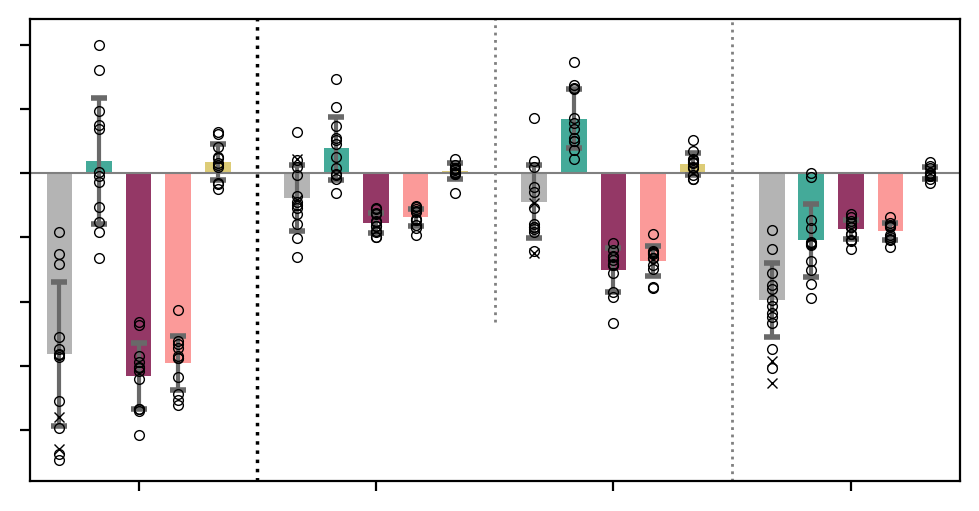

In [16]:
#---
# EPS
#---

plot_eps = True

if plot_eps:
    fig, axs = plt.subplots(1,1,figsize=(6,3), dpi=dpicnt,\
                            gridspec_kw={'width_ratios': [1],\
                                         'height_ratios': [1]})

    ax = plt.subplot2grid((1,1), (0,0))#, colspan=6)
    ax.hlines(0,np.min(x_pos)-0.75,np.max(x_pos)+0.75,color='grey',linewidth=0.75)

    #-----
    # subregion: all
    #-----
    rr=ind_ss1
    col=0
    if check_numbers:
        print ('######')
        print ('Contemporary flux in',subregions[rr])
        print ('######')
    # contemporary
    alpha1 = alpha_contemp
    riv = factor*biome_area_river[rr]*add_to_models[rr]
    m_mean = np.mean(factor2*biome_area_models_A[ind_not_those,rr]*flux_models_contemp_subareas[ind_not_those,rr]+riv,axis=0)
    m_std  = np.std(factor2*biome_area_models_A[ind_not_those,rr]*flux_models_contemp_subareas[ind_not_those,rr],axis=0)
    if check_numbers:
        print ('river flux:',riv)
    if check_numbers:
        print ('Multi-model mean:',m_mean)
    ax.bar(x_pos[col,0],m_mean,width,color=color1,alpha=alpha1,yerr=m_std,\
                    error_kw=whisker_properties,label=label1)
    for mm in range(0,len(models_A)):
        if check_numbers:
            ff = factor2*biome_area_models_A[mm,rr]*flux_models_contemp_subareas[mm,rr]
            reg = factor*biome_area_river[rr]* add_to_models[rr]
            print (models_A[mm],ff+reg)
            del ff,reg
        if models_A[mm] in ['FESOM_REcoM_HR','MOM6-COBALT2-Princeton','MOM6-Princeton']:
            ax.plot(x_pos[col,0],factor2*biome_area_models_A[mm,rr]*flux_models_contemp_subareas[mm,rr]+\
                factor*biome_area_river[rr]*add_to_models[rr],\
                 markeredgecolor=color_dots,marker='x',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None") 
        else:
            ax.plot(x_pos[col,0],factor2*biome_area_models_A[mm,rr]*flux_models_contemp_subareas[mm,rr]+\
                factor*biome_area_river[rr]*add_to_models[rr],\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None") 
    # nat
    alpha1 = alpha_nat
    m_mean = np.mean(factor2*biome_area_models_D[:,rr]*flux_models_nat_subareas[:,rr],axis=0)
    m_std  = np.std(factor2*biome_area_models_D[:,rr]*flux_models_nat_subareas[:,rr],axis=0)
    if check_numbers:
        nat1 = m_mean
        print ('avg natural:',m_mean)
    ax.bar(x_pos[col,1],m_mean,width,color=color2,alpha=alpha1,yerr=m_std,\
                    error_kw=whisker_properties,label=label2)
    for mm in range(0,len(models_D)):
        ax.plot(x_pos[col,1],factor2*biome_area_models_D[mm,rr]*flux_models_nat_subareas[mm,rr],\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None") 
    # anth
    alpha1 = alpha_anth
    m_mean = np.mean(factor2*biome_area_models_AD[:,rr]*flux_models_anth_subareas[:,rr],axis=0)
    m_std  = np.std(factor2*biome_area_models_AD[:,rr]*flux_models_anth_subareas[:,rr],axis=0)
    if check_numbers:
        print ('avg anthropogenic:',m_mean)
        print ('CHECK nat+anth+riv (should be equal to multi-model mean):',m_mean+nat1+riv)
    ax.bar(x_pos[col,2],m_mean,width,color=color3,alpha=alpha1,yerr=m_std,\
                    error_kw=whisker_properties,label=label3)
    for mm in range(0,len(models_AD)):
        ax.plot(x_pos[col,2],factor2*biome_area_models_AD[mm,rr]*flux_models_anth_subareas[mm,rr],\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None")
    # CO2 effect only (anth,ss)
    alpha1 = alpha_co2
    m_mean = np.mean(factor2*biome_area_models_CB[:,rr]*flux_models_anth_ss_subareas[:,rr],axis=0)
    m_std  = np.std(factor2*biome_area_models_CB[:,rr]*flux_models_anth_ss_subareas[:,rr],axis=0)
    ax.bar(x_pos[col,3],m_mean,width,color=color4,alpha=alpha1,yerr=m_std,\
                    error_kw=whisker_properties,label=label4)
    for mm in range(0,len(models_CB)):
        ax.plot(x_pos[col,3],factor2*biome_area_models_CB[mm,rr]*flux_models_anth_ss_subareas[mm,rr],\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None")
    # climate
    alpha1 = alpha_clim
    m_mean = np.mean(factor2*biome_area_models_AC[:,rr]*flux_models_anth_ns_nat_ns_subareas[:,rr],axis=0)
    m_std  = np.std(factor2*biome_area_models_AC[:,rr]*flux_models_anth_ns_nat_ns_subareas[:,rr],axis=0)
    ax.bar(x_pos[col,4],m_mean,width,color=color5,alpha=alpha1,yerr=m_std,\
                    error_kw=whisker_properties,label=label5)
    for mm in range(0,len(models_AC)):
        ax.plot(x_pos[col,4],factor2*biome_area_models_AC[mm,rr]*flux_models_anth_ns_nat_ns_subareas[mm,rr],\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None")
    print ('')
    print (subregions[rr]+', avg climate effect: '+str(m_mean))


    #-----
    # subregion: STSS
    #-----
    rr=ind_ss2
    col=1
    # contemporary
    alpha1 = alpha_contemp
    riv = factor*biome_area_river[rr]*add_to_models[rr]
    m_mean = np.mean(factor2*biome_area_models_A[ind_not_those,rr]*flux_models_contemp_subareas[ind_not_those,rr]+riv,axis=0)
    m_std  = np.std(factor2*biome_area_models_A[ind_not_those,rr]*flux_models_contemp_subareas[ind_not_those,rr],axis=0)
    ax.bar(x_pos[col,0],m_mean,width,color=color1,alpha=alpha1,yerr=m_std,\
                    error_kw=whisker_properties)#,label='contemporary FCO$_{2}$')
    for mm in range(0,len(models_A)):
        if models_A[mm] in ['FESOM_REcoM_HR','MOM6-COBALT2-Princeton','MOM6-Princeton']:
            ax.plot(x_pos[col,0],factor2*biome_area_models_A[mm,rr]*flux_models_contemp_subareas[mm,rr]+\
                factor*biome_area_river[rr]*add_to_models[rr],\
                 markeredgecolor=color_dots,marker='x',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None") 
        else:
            ax.plot(x_pos[col,0],factor2*biome_area_models_A[mm,rr]*flux_models_contemp_subareas[mm,rr]+\
                factor*biome_area_river[rr]*add_to_models[rr],\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None") 
    # nat
    alpha1 = alpha_nat
    m_mean = np.mean(factor2*biome_area_models_D[:,rr]*flux_models_nat_subareas[:,rr],axis=0)
    m_std  = np.std(factor2*biome_area_models_D[:,rr]*flux_models_nat_subareas[:,rr],axis=0)
    ax.bar(x_pos[col,1],m_mean,width,color=color2,alpha=alpha1,yerr=m_std,\
                    error_kw=whisker_properties)#,label='natural FCO$_{2}$')
    for mm in range(0,len(models_D)):
        ax.plot(x_pos[col,1],factor2*biome_area_models_D[mm,rr]*flux_models_nat_subareas[mm,rr],\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None") 
    # anth
    alpha1 = alpha_anth
    m_mean = np.mean(factor2*biome_area_models_AD[:,rr]*flux_models_anth_subareas[:,rr],axis=0)
    m_std  = np.std(factor2*biome_area_models_AD[:,rr]*flux_models_anth_subareas[:,rr],axis=0)
    ax.bar(x_pos[col,2],m_mean,width,color=color3,alpha=alpha1,yerr=m_std,\
                    error_kw=whisker_properties)#,label='anthropogenic FCO$_{2}$')
    for mm in range(0,len(models_AD)):
        ax.plot(x_pos[col,2],factor2*biome_area_models_AD[mm,rr]*flux_models_anth_subareas[mm,rr],\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None")
    # CO2 effect only (anth,ss)
    alpha1 = alpha_co2
    m_mean = np.mean(factor2*biome_area_models_CB[:,rr]*flux_models_anth_ss_subareas[:,rr],axis=0)
    m_std  = np.std(factor2*biome_area_models_CB[:,rr]*flux_models_anth_ss_subareas[:,rr],axis=0)
    ax.bar(x_pos[col,3],m_mean,width,color=color4,alpha=alpha1,yerr=m_std,\
                    error_kw=whisker_properties)#,label='CO2 effect on FCO$_{2}$')
    for mm in range(0,len(models_CB)):
        ax.plot(x_pos[col,3],factor2*biome_area_models_CB[mm,rr]*flux_models_anth_ss_subareas[mm,rr],\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None")
    # climate
    alpha1 = alpha_clim
    m_mean = np.mean(factor2*biome_area_models_AC[:,rr]*flux_models_anth_ns_nat_ns_subareas[:,rr],axis=0)
    m_std  = np.std(factor2*biome_area_models_AC[:,rr]*flux_models_anth_ns_nat_ns_subareas[:,rr],axis=0)
    ax.bar(x_pos[col,4],m_mean,width,color=color5,alpha=alpha1,yerr=m_std,\
                    error_kw=whisker_properties)#,label='climate effect on total FCO$_{2}$')
    for mm in range(0,len(models_AC)):
        ax.plot(x_pos[col,4],factor2*biome_area_models_AC[mm,rr]*flux_models_anth_ns_nat_ns_subareas[mm,rr],\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None")
    print (subregions[rr]+', avg climate effect: '+str(m_mean))

    #-----
    # subregion: SPSS
    #-----
    rr=ind_ss3
    col=2
    # contemporary
    alpha1 = alpha_contemp
    riv = factor*biome_area_river[rr]*add_to_models[rr]
    m_mean = np.mean(factor2*biome_area_models_A[ind_not_those,rr]*flux_models_contemp_subareas[ind_not_those,rr]+riv,axis=0)
    m_std  = np.std(factor2*biome_area_models_A[ind_not_those,rr]*flux_models_contemp_subareas[ind_not_those,rr],axis=0)
    ax.bar(x_pos[col,0],m_mean,width,color=color1,alpha=alpha1,yerr=m_std,\
                    error_kw=whisker_properties)#,label='contemporary FCO$_{2}$')
    for mm in range(0,len(models_A)):
        if models_A[mm] in ['FESOM_REcoM_HR','MOM6-COBALT2-Princeton','MOM6-Princeton']:
            ax.plot(x_pos[col,0],factor2*biome_area_models_A[mm,rr]*flux_models_contemp_subareas[mm,rr]+\
                factor*biome_area_river[rr]*add_to_models[rr],\
                 markeredgecolor=color_dots,marker='x',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None") 
        else:
            ax.plot(x_pos[col,0],factor2*biome_area_models_A[mm,rr]*flux_models_contemp_subareas[mm,rr]+\
                factor*biome_area_river[rr]*add_to_models[rr],\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None") 
    # nat
    alpha1 = alpha_nat
    m_mean = np.mean(factor2*biome_area_models_D[:,rr]*flux_models_nat_subareas[:,rr],axis=0)
    m_std  = np.std(factor2*biome_area_models_D[:,rr]*flux_models_nat_subareas[:,rr],axis=0)
    ax.bar(x_pos[col,1],m_mean,width,color=color2,alpha=alpha1,yerr=m_std,\
                    error_kw=whisker_properties)#,label='natural FCO$_{2}$')
    for mm in range(0,len(models_D)):
        ax.plot(x_pos[col,1],factor2*biome_area_models_D[mm,rr]*flux_models_nat_subareas[mm,rr],\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None") 
    # anth
    alpha1 = alpha_anth
    m_mean = np.mean(factor2*biome_area_models_AD[:,rr]*flux_models_anth_subareas[:,rr],axis=0)
    m_std  = np.std(factor2*biome_area_models_AD[:,rr]*flux_models_anth_subareas[:,rr],axis=0)
    ax.bar(x_pos[col,2],m_mean,width,color=color3,alpha=alpha1,yerr=m_std,\
                    error_kw=whisker_properties)#,label='anthropogenic FCO$_{2}$')
    for mm in range(0,len(models_AD)):
        ax.plot(x_pos[col,2],factor2*biome_area_models_AD[mm,rr]*flux_models_anth_subareas[mm,rr],\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None")
    # CO2 effect only (anth,ss)
    alpha1 = alpha_co2
    m_mean = np.mean(factor2*biome_area_models_CB[:,rr]*flux_models_anth_ss_subareas[:,rr],axis=0)
    m_std  = np.std(factor2*biome_area_models_CB[:,rr]*flux_models_anth_ss_subareas[:,rr],axis=0)
    ax.bar(x_pos[col,3],m_mean,width,color=color4,alpha=alpha1,yerr=m_std,\
                    error_kw=whisker_properties)#,label='CO2 effect on FCO$_{2}$')
    for mm in range(0,len(models_CB)):
        ax.plot(x_pos[col,3],factor2*biome_area_models_CB[mm,rr]*flux_models_anth_ss_subareas[mm,rr],\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None")
    # climate
    alpha1 = alpha_clim
    m_mean = np.mean(factor2*biome_area_models_AC[:,rr]*flux_models_anth_ns_nat_ns_subareas[:,rr],axis=0)
    m_std  = np.std(factor2*biome_area_models_AC[:,rr]*flux_models_anth_ns_nat_ns_subareas[:,rr],axis=0)
    ax.bar(x_pos[col,4],m_mean,width,color=color5,alpha=alpha1,yerr=m_std,\
                    error_kw=whisker_properties)#,label='climate effect on total FCO$_{2}$')
    for mm in range(0,len(models_AC)):
        ax.plot(x_pos[col,4],factor2*biome_area_models_AC[mm,rr]*flux_models_anth_ns_nat_ns_subareas[mm,rr],\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None")
    print (subregions[rr]+', avg climate effect: '+str(m_mean))

    #-----
    # subregion: ICE
    #-----
    rr=ind_ss4
    col=3
    # contemporary
    alpha1 = alpha_contemp
    riv = factor*biome_area_river[rr]*add_to_models[rr]
    m_mean = np.mean(factor2*biome_area_models_A[ind_not_those,rr]*flux_models_contemp_subareas[ind_not_those,rr]+riv,axis=0)
    m_std  = np.std(factor2*biome_area_models_A[ind_not_those,rr]*flux_models_contemp_subareas[ind_not_those,rr],axis=0)
    ax.bar(x_pos[col,0],m_mean,width,color=color1,alpha=alpha1,yerr=m_std,\
                    error_kw=whisker_properties)#,label='contemporary FCO$_{2}$')
    for mm in range(0,len(models_A)):
        if models_A[mm] in ['FESOM_REcoM_HR','MOM6-COBALT2-Princeton','MOM6-Princeton']:
            ax.plot(x_pos[col,0],factor2*biome_area_models_A[mm,rr]*flux_models_contemp_subareas[mm,rr]+\
                factor*biome_area_river[rr]*add_to_models[rr],\
                 markeredgecolor=color_dots,marker='x',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None") 
        else:
            ax.plot(x_pos[col,0],factor2*biome_area_models_A[mm,rr]*flux_models_contemp_subareas[mm,rr]+\
                factor*biome_area_river[rr]*add_to_models[rr],\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None") 
    # nat
    alpha1 = alpha_nat
    m_mean = np.mean(factor2*biome_area_models_D[:,rr]*flux_models_nat_subareas[:,rr],axis=0)
    m_std  = np.std(factor2*biome_area_models_D[:,rr]*flux_models_nat_subareas[:,rr],axis=0)
    ax.bar(x_pos[col,1],m_mean,width,color=color2,alpha=alpha1,yerr=m_std,\
                    error_kw=whisker_properties)#,label='natural FCO$_{2}$')
    for mm in range(0,len(models_D)):
        ax.plot(x_pos[col,1],factor2*biome_area_models_D[mm,rr]*flux_models_nat_subareas[mm,rr],\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None") 
    # anth
    alpha1 = alpha_anth
    m_mean = np.mean(factor2*biome_area_models_AD[:,rr]*flux_models_anth_subareas[:,rr],axis=0)
    m_std  = np.std(factor2*biome_area_models_AD[:,rr]*flux_models_anth_subareas[:,rr],axis=0)
    ax.bar(x_pos[col,2],m_mean,width,color=color3,alpha=alpha1,yerr=m_std,\
                    error_kw=whisker_properties)#,label='anthropogenic FCO$_{2}$')
    for mm in range(0,len(models_AD)):
        ax.plot(x_pos[col,2],factor2*biome_area_models_AD[mm,rr]*flux_models_anth_subareas[mm,rr],\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None")
    # CO2 effect only (anth,ss)
    alpha1 = alpha_co2
    m_mean = np.mean(factor2*biome_area_models_CB[:,rr]*flux_models_anth_ss_subareas[:,rr],axis=0)
    m_std  = np.std(factor2*biome_area_models_CB[:,rr]*flux_models_anth_ss_subareas[:,rr],axis=0)
    ax.bar(x_pos[col,3],m_mean,width,color=color4,alpha=alpha1,yerr=m_std,\
                    error_kw=whisker_properties)#,label='CO2 effect on FCO$_{2}$')
    for mm in range(0,len(models_CB)):
        ax.plot(x_pos[col,3],factor2*biome_area_models_CB[mm,rr]*flux_models_anth_ss_subareas[mm,rr],\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None")
    # climate
    alpha1 = alpha_clim
    m_mean = np.mean(factor2*biome_area_models_AC[:,rr]*flux_models_anth_ns_nat_ns_subareas[:,rr],axis=0)
    m_std  = np.std(factor2*biome_area_models_AC[:,rr]*flux_models_anth_ns_nat_ns_subareas[:,rr],axis=0)
    ax.bar(x_pos[col,4],m_mean,width,color=color5,alpha=alpha1,yerr=m_std,\
                    error_kw=whisker_properties)#,label='climate effect on total FCO$_{2}$')
    for mm in range(0,len(models_AC)):
        ax.plot(x_pos[col,4],factor2*biome_area_models_AC[mm,rr]*flux_models_anth_ns_nat_ns_subareas[mm,rr],\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None")
    print (subregions[rr]+', avg climate effect: '+str(m_mean))


    ax.set_xlim((np.min(x_pos)-0.75,np.max(x_pos)+0.75))
    ax.set_xticks([x_pos[0,2],x_pos[1,2],x_pos[2,2],x_pos[3,2]])
    ax.set_xticklabels([],fontweight='bold')
    ax.set_ylim((-1.2,0.6))
    ylim1,ylim2 = ax.get_ylim()
    ax.vlines(6,ylim1,ylim2,linestyle=':',color='black',linewidth=1.25)

    ax.vlines(12,-0.58,ylim2,linestyle=':',color='grey',linewidth=1.0)
    #ax.vlines(18,-0.58,ylim2,linestyle=':',color='grey',linewidth=1.0)
    ax.vlines(18,ylim1,ylim2,linestyle=':',color='grey',linewidth=1.0)

    ax.set_yticks([-1.0,-0.75,-0.5,-0.25,0,0.25,0.5])
    ax.set_yticklabels([])

    for label in ax.yaxis.get_majorticklabels():
            label.set_size(fs_text-2)

    for label in ax.xaxis.get_majorticklabels():
            label.set_size(fs_text-2)
            #label.set_rotation(90)

    filename1 = 'fig3_bar_plot_CO2_flux_anth_nat_climate_'+str(year1)+'_'+str(year2)
    plt.savefig(save_to_dir+filename1+'.eps',dpi = dpicnt, bbox_inches='tight',format='eps')

    plt.show()



In [17]:
#----
# plotting function
#----

def plot_bars_for_3_regions(ax,ind_ss,add_to_models,\
                            flux_models_contemp_subareas,flux_models_nat_subareas,\
                            flux_models_anth_subareas,flux_models_anth_ss_subareas,\
                            flux_models_anth_ns_nat_ns_subareas,\
                           biome_area_river,biome_area_models_A,biome_area_models_D,\
                           biome_area_models_AD,biome_area_models_CB,biome_area_models_AC,subregions,\
                           panel_label,counter):
    
    factor2 = -1*365.*86400.*12.011/1e15
    factor  = 365.*86400.*12.011/1e15 # for river fluxes

    width = 0.65
    shift = 0.2
    fs_text = 12
    dpicnt  =200

    #blue for Fnet
    #green for Fnat (dark) and clim (light)
    #pinkish for anthropogenic (dark) and CO2 (light)
    # indian red 205,92,92
    
    color1 = (180./255.,180./255.,180./255.) # contemporary, grey
    color2 = (68./255.,170./255.,153./255.) # natural, teal
    #color2 = (178./255.,223./255.,138./255.) # natural, light green
    
    color3 = (136./255.,34./255.,85./255.) #(205./255.,92./255.,92./255.) # anthropogenic, dark red
    color4 = (251./255.,154./255.,153./255.) #(204./255.,102./255.,119./255.) # CO2 effect, light red
    color5 = (221./255.,204./255.,119./255.) # climate effect, sand

    #color1 = (31./255.,120./255.,180./255.) # contemporary, blue
    #color2 = (51./255.,160./255.,44./255.) # natural, dark green
    #color3 = (165./255.,42./255.,42./255.) #(205./255.,92./255.,92./255.) # anthropogenic, dark red
    #color4 = (251./255.,154./255.,153./255.) # CO2 effect, light red
    #color5 = (178./255.,223./255.,138./255.) # climate effect, light green

    #color1 = (251./255.,154./255.,153./255.) # contemporary, light red
    #color2 = (31./255.,120./255.,180./255.) # natural, dark blue
    #color3 = (51./255.,160./255.,44./255.) # anthropogenic, dark green
    #color4 = (178./255.,223./255.,138./255.) # CO2 effect, light green
    #color5 = (166./255.,206./255.,227./255.) # climate effect, light blue

    alpha_contemp = 1.0
    alpha_nat     = 1.0#0.8
    alpha_anth    = 1.0#0.9#1.0#0.6
    alpha_co2     = 1.0#0.4
    alpha_clim    = 1.0#0.2

    #natural = '#1f78b4',  # dark blue
    #climate_effect = '#a6cee3',  # light blue
    #co2_effect = '#b2df8a',  # light green
    #anthropogenic = '#33a02c',  # dark green
    #contemporary = '#fb9a99' # light red/pink

    #166,206,227 # light blue
    #31,120,180 # dark blue
    #178,223,138 # light green
    #51,160,44 # dark green
    #251,154,153 # light red

    color_dots = 'black'
    # markers for each model/data product
    circle_size=3.5
    edgewidth=0.5
    # whiskers for model/data spread
    whisker_properties = dict(lw=1.5, capsize=3, capthick=2,ecolor='dimgrey')

    unit = 'FCO$_{2}$ (Pg C yr$^{-1}$)'

    x_pos =np.asarray([1,2,3,4,5,\
        7,8,9,10,11,\
        13,14,15,16,17])
    x_pos = np.reshape(x_pos,[3,5])

    check_numbers = False # option to print some numbers

    label1 = 'net: F$_{net}$' #'contemporary FCO$_{2}$'
    label2 = 'natural: F$_{nat,ns+nat,ss}$' #'natural FCO$_{2}$'
    label3 = 'anthropogenic: F$_{ant,ns+ant,ss}$' #'anthropogenic FCO$_{2}$'
    label4 = 'CO$_{2}$ effect: F$_{ant,ss}$' #'CO2 effect on FCO$_{2}$'
    label5 = 'climate effect: F$_{nat,ns+ant,ns}$' #'climate effect on total FCO$_{2}$'
    
    ax.hlines(0,np.min(x_pos)-0.75,np.max(x_pos)+0.75,color='grey',linewidth=0.75)
    
    #-----
    # subregion 1
    #-----
    rr=ind_ss[0]
    print ('Plot ',subregions[rr])
    col=0
    #if check_numbers:
    #    print '######'
    #    print 'Contemporary flux in',subregions[rr]
    #    print '######'
    # contemporary
    alpha1 = alpha_contemp
    riv = factor*biome_area_river[rr]*add_to_models[rr]
    m_mean = np.mean(factor2*biome_area_models_A[ind_not_those,rr]*flux_models_contemp_subareas[ind_not_those,rr]+riv,axis=0)
    m_std  = np.std(factor2*biome_area_models_A[ind_not_those,rr]*flux_models_contemp_subareas[ind_not_those,rr],axis=0)
    #if check_numbers:
    #    print 'river flux:',riv
    #if check_numbers:
    #    print 'Multi-model mean:',m_mean
    ax.bar(x_pos[col,0],m_mean,width,color=color1,alpha=alpha1,yerr=m_std,\
                    error_kw=whisker_properties,label=label1)
    for mm in range(0,len(models_A)):
        #if check_numbers:
        #    ff = factor2*biome_area_models_A[mm,rr]*flux_models_contemp_subareas[mm,rr]
        #    reg = factor*biome_area_river[rr]* add_to_models[rr]
        #    print models_A[mm],ff+reg
        #    del ff,reg
        if models_A[mm] in ['FESOM_REcoM_HR','MOM6-COBALT2-Princeton','MOM6-Princeton']:
            ax.plot(x_pos[col,0],factor2*biome_area_models_A[mm,rr]*flux_models_contemp_subareas[mm,rr]+\
                factor*biome_area_river[rr]*add_to_models[rr],\
                 markeredgecolor=color_dots,marker='x',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None") 
        else:
            ax.plot(x_pos[col,0],factor2*biome_area_models_A[mm,rr]*flux_models_contemp_subareas[mm,rr]+\
                factor*biome_area_river[rr]*add_to_models[rr],\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None") 
    # nat
    alpha1 = alpha_nat
    m_mean = np.mean(factor2*biome_area_models_D[:,rr]*flux_models_nat_subareas[:,rr],axis=0)
    m_std  = np.std(factor2*biome_area_models_D[:,rr]*flux_models_nat_subareas[:,rr],axis=0)
    #if check_numbers:
    #    nat1 = m_mean
    #    print 'avg natural:',m_mean
    ax.bar(x_pos[col,1],m_mean,width,color=color2,alpha=alpha1,yerr=m_std,\
                    error_kw=whisker_properties,label=label2)
    for mm in range(0,len(models_D)):
        ax.plot(x_pos[col,1],factor2*biome_area_models_D[mm,rr]*flux_models_nat_subareas[mm,rr],\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None") 
    # anth
    alpha1 = alpha_anth
    m_mean = np.mean(factor2*biome_area_models_AD[:,rr]*flux_models_anth_subareas[:,rr],axis=0)
    m_std  = np.std(factor2*biome_area_models_AD[:,rr]*flux_models_anth_subareas[:,rr],axis=0)
    #if check_numbers:
    #    print 'avg anthropogenic:',m_mean
    #    print 'CHECK nat+anth+riv (should be equal to multi-model mean):',m_mean+nat1+riv
    ax.bar(x_pos[col,2],m_mean,width,color=color3,alpha=alpha1,yerr=m_std,\
                    error_kw=whisker_properties,label=label3)
    for mm in range(0,len(models_AD)):
        ax.plot(x_pos[col,2],factor2*biome_area_models_AD[mm,rr]*flux_models_anth_subareas[mm,rr],\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None")
    # CO2 effect only (anth,ss)
    alpha1 = alpha_co2
    m_mean = np.mean(factor2*biome_area_models_CB[:,rr]*flux_models_anth_ss_subareas[:,rr],axis=0)
    m_std  = np.std(factor2*biome_area_models_CB[:,rr]*flux_models_anth_ss_subareas[:,rr],axis=0)
    ax.bar(x_pos[col,3],m_mean,width,color=color4,alpha=alpha1,yerr=m_std,\
                    error_kw=whisker_properties,label=label4)
    for mm in range(0,len(models_CB)):
        ax.plot(x_pos[col,3],factor2*biome_area_models_CB[mm,rr]*flux_models_anth_ss_subareas[mm,rr],\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None")
    # climate
    alpha1 = alpha_clim
    m_mean = np.mean(factor2*biome_area_models_AC[:,rr]*flux_models_anth_ns_nat_ns_subareas[:,rr],axis=0)
    m_std  = np.std(factor2*biome_area_models_AC[:,rr]*flux_models_anth_ns_nat_ns_subareas[:,rr],axis=0)
    ax.bar(x_pos[col,4],m_mean,width,color=color5,alpha=alpha1,yerr=m_std,\
                    error_kw=whisker_properties,label=label5)
    for mm in range(0,len(models_AC)):
        ax.plot(x_pos[col,4],factor2*biome_area_models_AC[mm,rr]*flux_models_anth_ns_nat_ns_subareas[mm,rr],\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None")
    

    #-----
    # subregion2
    #-----
    rr=ind_ss[1]
    print ('Plot ',subregions[rr])
    col=1
    # contemporary
    alpha1 = alpha_contemp
    riv = factor*biome_area_river[rr]*add_to_models[rr]
    m_mean = np.mean(factor2*biome_area_models_A[ind_not_those,rr]*flux_models_contemp_subareas[ind_not_those,rr]+riv,axis=0)
    m_std  = np.std(factor2*biome_area_models_A[ind_not_those,rr]*flux_models_contemp_subareas[ind_not_those,rr],axis=0)
    ax.bar(x_pos[col,0],m_mean,width,color=color1,alpha=alpha1,yerr=m_std,\
                    error_kw=whisker_properties)#,label='contemporary FCO$_{2}$')
    for mm in range(0,len(models_A)):
        if models_A[mm] in ['FESOM_REcoM_HR','MOM6-COBALT2-Princeton','MOM6-Princeton']:
            ax.plot(x_pos[col,0],factor2*biome_area_models_A[mm,rr]*flux_models_contemp_subareas[mm,rr]+\
                factor*biome_area_river[rr]*add_to_models[rr],\
                 markeredgecolor=color_dots,marker='x',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None") 
        else:
            ax.plot(x_pos[col,0],factor2*biome_area_models_A[mm,rr]*flux_models_contemp_subareas[mm,rr]+\
                factor*biome_area_river[rr]*add_to_models[rr],\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None") 
    # nat
    alpha1 = alpha_nat
    m_mean = np.mean(factor2*biome_area_models_D[:,rr]*flux_models_nat_subareas[:,rr],axis=0)
    m_std  = np.std(factor2*biome_area_models_D[:,rr]*flux_models_nat_subareas[:,rr],axis=0)
    ax.bar(x_pos[col,1],m_mean,width,color=color2,alpha=alpha1,yerr=m_std,\
                    error_kw=whisker_properties)#,label='natural FCO$_{2}$')
    for mm in range(0,len(models_D)):
        ax.plot(x_pos[col,1],factor2*biome_area_models_D[mm,rr]*flux_models_nat_subareas[mm,rr],\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None") 
    # anth
    alpha1 = alpha_anth
    m_mean = np.mean(factor2*biome_area_models_AD[:,rr]*flux_models_anth_subareas[:,rr],axis=0)
    m_std  = np.std(factor2*biome_area_models_AD[:,rr]*flux_models_anth_subareas[:,rr],axis=0)
    ax.bar(x_pos[col,2],m_mean,width,color=color3,alpha=alpha1,yerr=m_std,\
                    error_kw=whisker_properties)#,label='anthropogenic FCO$_{2}$')
    for mm in range(0,len(models_AD)):
        ax.plot(x_pos[col,2],factor2*biome_area_models_AD[mm,rr]*flux_models_anth_subareas[mm,rr],\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None")
    # CO2 effect only (anth,ss)
    alpha1 = alpha_co2
    m_mean = np.mean(factor2*biome_area_models_CB[:,rr]*flux_models_anth_ss_subareas[:,rr],axis=0)
    m_std  = np.std(factor2*biome_area_models_CB[:,rr]*flux_models_anth_ss_subareas[:,rr],axis=0)
    ax.bar(x_pos[col,3],m_mean,width,color=color4,alpha=alpha1,yerr=m_std,\
                    error_kw=whisker_properties)#,label='CO2 effect on FCO$_{2}$')
    for mm in range(0,len(models_CB)):
        ax.plot(x_pos[col,3],factor2*biome_area_models_CB[mm,rr]*flux_models_anth_ss_subareas[mm,rr],\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None")
    # climate
    alpha1 = alpha_clim
    m_mean = np.mean(factor2*biome_area_models_AC[:,rr]*flux_models_anth_ns_nat_ns_subareas[:,rr],axis=0)
    m_std  = np.std(factor2*biome_area_models_AC[:,rr]*flux_models_anth_ns_nat_ns_subareas[:,rr],axis=0)
    ax.bar(x_pos[col,4],m_mean,width,color=color5,alpha=alpha1,yerr=m_std,\
                    error_kw=whisker_properties)#,label='climate effect on total FCO$_{2}$')
    for mm in range(0,len(models_AC)):
        ax.plot(x_pos[col,4],factor2*biome_area_models_AC[mm,rr]*flux_models_anth_ns_nat_ns_subareas[mm,rr],\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None")
    
    #-----
    # subregion3
    #-----
    rr=ind_ss[2]
    print ('Plot ',subregions[rr])
    col=2
    # contemporary
    alpha1 = alpha_contemp
    riv = factor*biome_area_river[rr]*add_to_models[rr]
    m_mean = np.mean(factor2*biome_area_models_A[ind_not_those,rr]*flux_models_contemp_subareas[ind_not_those,rr]+riv,axis=0)
    m_std  = np.std(factor2*biome_area_models_A[ind_not_those,rr]*flux_models_contemp_subareas[ind_not_those,rr],axis=0)
    ax.bar(x_pos[col,0],m_mean,width,color=color1,alpha=alpha1,yerr=m_std,\
                    error_kw=whisker_properties)#,label='contemporary FCO$_{2}$')
    for mm in range(0,len(models_A)):
        if models_A[mm] in ['FESOM_REcoM_HR','MOM6-COBALT2-Princeton','MOM6-Princeton']:
            ax.plot(x_pos[col,0],factor2*biome_area_models_A[mm,rr]*flux_models_contemp_subareas[mm,rr]+\
                factor*biome_area_river[rr]*add_to_models[rr],\
                 markeredgecolor=color_dots,marker='x',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None") 
        else:
            ax.plot(x_pos[col,0],factor2*biome_area_models_A[mm,rr]*flux_models_contemp_subareas[mm,rr]+\
                factor*biome_area_river[rr]*add_to_models[rr],\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None") 
    # nat
    alpha1 = alpha_nat
    m_mean = np.mean(factor2*biome_area_models_D[:,rr]*flux_models_nat_subareas[:,rr],axis=0)
    m_std  = np.std(factor2*biome_area_models_D[:,rr]*flux_models_nat_subareas[:,rr],axis=0)
    ax.bar(x_pos[col,1],m_mean,width,color=color2,alpha=alpha1,yerr=m_std,\
                    error_kw=whisker_properties)#,label='natural FCO$_{2}$')
    for mm in range(0,len(models_D)):
        ax.plot(x_pos[col,1],factor2*biome_area_models_D[mm,rr]*flux_models_nat_subareas[mm,rr],\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None") 
    # anth
    alpha1 = alpha_anth
    m_mean = np.mean(factor2*biome_area_models_AD[:,rr]*flux_models_anth_subareas[:,rr],axis=0)
    m_std  = np.std(factor2*biome_area_models_AD[:,rr]*flux_models_anth_subareas[:,rr],axis=0)
    ax.bar(x_pos[col,2],m_mean,width,color=color3,alpha=alpha1,yerr=m_std,\
                    error_kw=whisker_properties)#,label='anthropogenic FCO$_{2}$')
    for mm in range(0,len(models_AD)):
        ax.plot(x_pos[col,2],factor2*biome_area_models_AD[mm,rr]*flux_models_anth_subareas[mm,rr],\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None")
    # CO2 effect only (anth,ss)
    alpha1 = alpha_co2
    m_mean = np.mean(factor2*biome_area_models_CB[:,rr]*flux_models_anth_ss_subareas[:,rr],axis=0)
    m_std  = np.std(factor2*biome_area_models_CB[:,rr]*flux_models_anth_ss_subareas[:,rr],axis=0)
    ax.bar(x_pos[col,3],m_mean,width,color=color4,alpha=alpha1,yerr=m_std,\
                    error_kw=whisker_properties)#,label='CO2 effect on FCO$_{2}$')
    for mm in range(0,len(models_CB)):
        ax.plot(x_pos[col,3],factor2*biome_area_models_CB[mm,rr]*flux_models_anth_ss_subareas[mm,rr],\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None")
    # climate
    alpha1 = alpha_clim
    m_mean = np.mean(factor2*biome_area_models_AC[:,rr]*flux_models_anth_ns_nat_ns_subareas[:,rr],axis=0)
    m_std  = np.std(factor2*biome_area_models_AC[:,rr]*flux_models_anth_ns_nat_ns_subareas[:,rr],axis=0)
    ax.bar(x_pos[col,4],m_mean,width,color=color5,alpha=alpha1,yerr=m_std,\
                    error_kw=whisker_properties)#,label='climate effect on total FCO$_{2}$')
    for mm in range(0,len(models_AC)):
        ax.plot(x_pos[col,4],factor2*biome_area_models_AC[mm,rr]*flux_models_anth_ns_nat_ns_subareas[mm,rr],\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None")
    
    if counter>0:
        ax.legend(loc='right',bbox_to_anchor=(0.5, 0.81), \
                  ncol=1,markerfirst=True,fancybox=False, \
                   frameon=False,shadow=False,prop={'size': 7}) 
        #ax.legend(loc='right',bbox_to_anchor=(1.0, 0.17), \
        #          ncol=1,markerfirst=False,fancybox=False, \
        #           frameon=False,shadow=False,prop={'size': 6}) 

    if counter>0:
        ax.annotate(panel_label,xy=(-0.18,0.98), xycoords='axes fraction',fontsize=fs_text+1,fontweight='bold')
    else:
        ax.annotate(panel_label,xy=(-0.16,0.98), xycoords='axes fraction',fontsize=fs_text+1,fontweight='bold') 
    
    ax.set_xlim((np.min(x_pos)-0.75,np.max(x_pos)+0.75))
    ax.set_xticks([x_pos[0,2],x_pos[1,2],x_pos[2,2]])
    ax.set_xticklabels([subregions[ind_ss[0]],subregions[ind_ss[1]],subregions[ind_ss[2]]],\
                       fontweight='bold')
    ax.set_ylim((-0.4,0.4))
    ylim1,ylim2 = ax.get_ylim()
    
    if counter>0:
        ax.set_yticks([-0.4,-0.2,0,0.2,0.4])
        ax.set_yticklabels([-0.4,-0.2,0,0.2,0.4])
        ax.set_ylabel(unit,fontsize=fs_text)
        ax.vlines(6,ylim1,0.12,linestyle=':',color='grey',linewidth=1.0)
        ax.vlines(6,0.38,0.4,linestyle=':',color='grey',linewidth=1.0)
        ax.vlines(12,ylim1,ylim2,linestyle=':',color='grey',linewidth=1.0)
    else:
        ax.set_yticks([-0.4,-0.2,0,0.2,0.4])
        #ax.set_yticklabels([])
        ax.set_yticklabels([-0.4,-0.2,0,0.2,0.4])
        ax.set_ylabel(unit,fontsize=fs_text)
        ax.vlines(6,ylim1,ylim2,linestyle=':',color='grey',linewidth=1.0)
        ax.vlines(12,ylim1,ylim2,linestyle=':',color='grey',linewidth=1.0)
        
    for label in ax.yaxis.get_majorticklabels():
            label.set_size(fs_text-2)

    for label in ax.xaxis.get_majorticklabels():
            label.set_size(fs_text-2)
            
    
    


Plot  STSS-Atl
Plot  STSS-Ind
Plot  STSS-Pac
Plot  SPSS-Atl
Plot  SPSS-Ind
Plot  SPSS-Pac
Plot  ICE-Atl
Plot  ICE-Ind
Plot  ICE-Pac


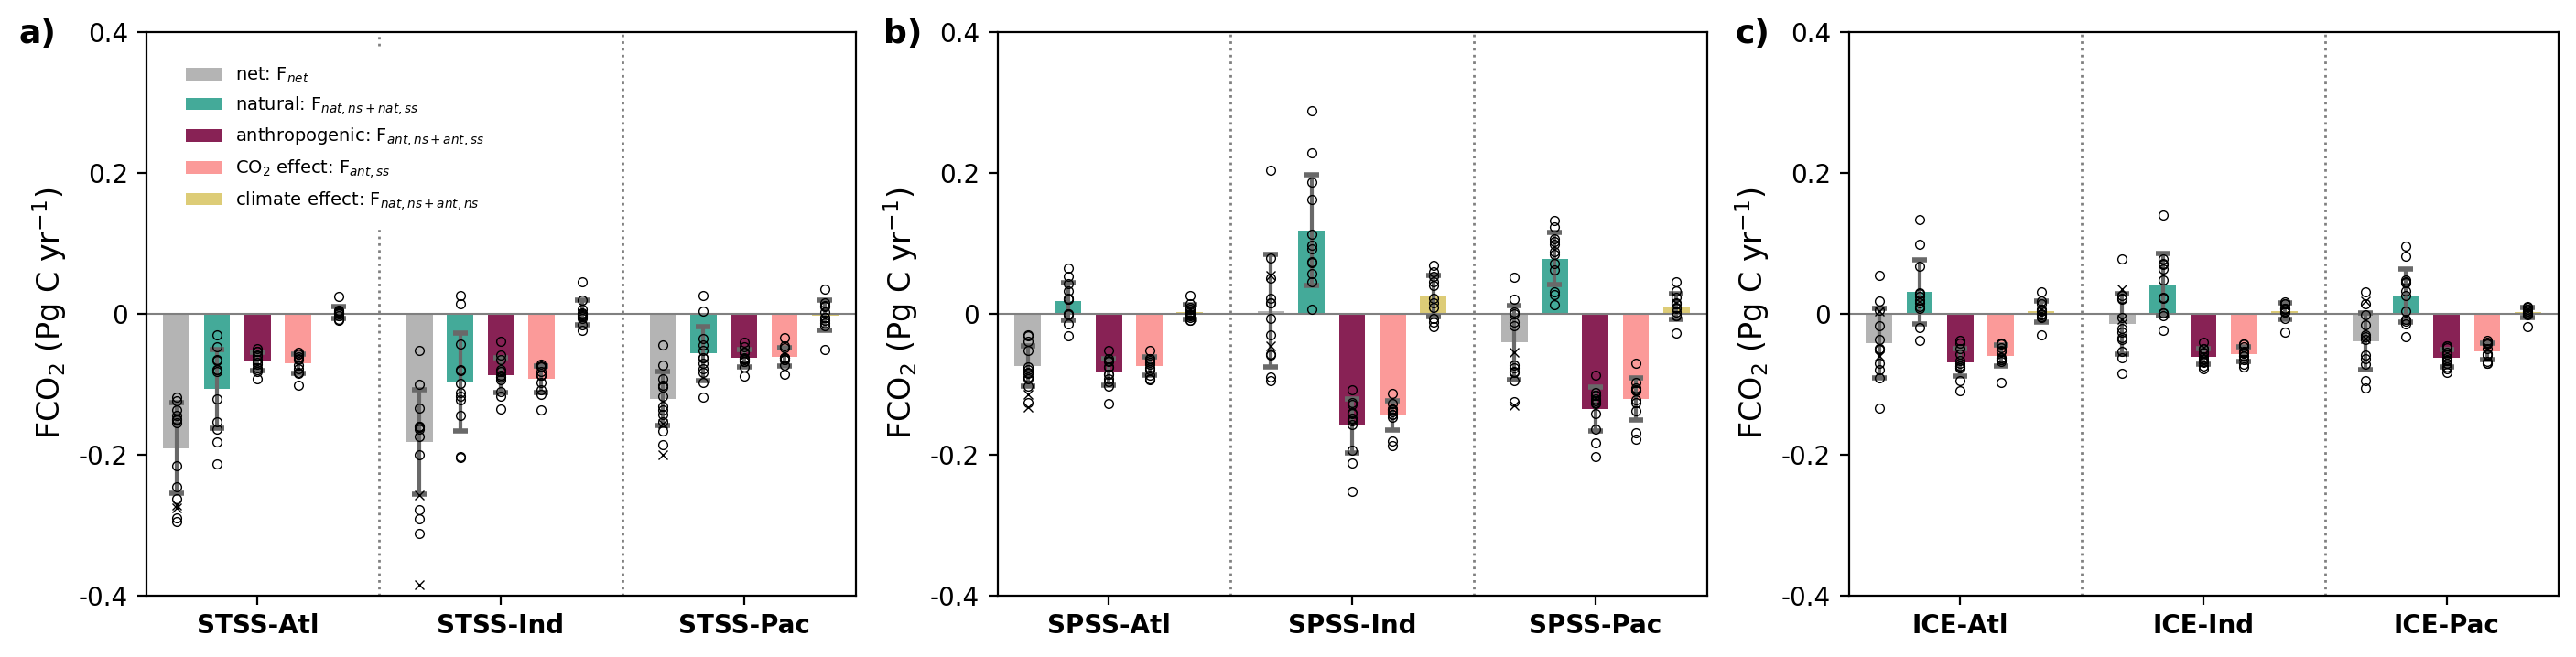

In [18]:
#----
# plot for all nine regions
#----

#('STSS-Atl', 'STSS-Ind', 'STSS-Pac', 
# 'SPSS-Atl', 'SPSS-Ind', 'SPSS-Pac',
# 'ICE-Atl', 'ICE-Ind', 'ICE-Pac', 'STSS', 'SPSS', 'ICE', 'all')

fig, axs = plt.subplots(1,3,figsize=(17,4), dpi=dpicnt,\
                            gridspec_kw={'width_ratios': [1,1,1],\
                                         'height_ratios': [1]})

ax1 = plt.subplot2grid((1,3), (0,0))
ax2 = plt.subplot2grid((1,3), (0,1))
ax3 = plt.subplot2grid((1,3), (0,2))

ax=ax1
plot_bars_for_3_regions(ax,[0,1,2],add_to_models,\
                            flux_models_contemp_subareas,flux_models_nat_subareas,\
                            flux_models_anth_subareas,flux_models_anth_ss_subareas,\
                            flux_models_anth_ns_nat_ns_subareas,\
                           biome_area_river,biome_area_models_A,biome_area_models_D,\
                           biome_area_models_AD,biome_area_models_CB,biome_area_models_AC,subregions,'a)',1)

ax=ax2
#ax.set_axis_off()
plot_bars_for_3_regions(ax,[3,4,5],add_to_models,\
                            flux_models_contemp_subareas,flux_models_nat_subareas,\
                            flux_models_anth_subareas,flux_models_anth_ss_subareas,\
                            flux_models_anth_ns_nat_ns_subareas,\
                           biome_area_river,biome_area_models_A,biome_area_models_D,\
                           biome_area_models_AD,biome_area_models_CB,biome_area_models_AC,subregions,'b)',0)

ax=ax3
#ax.set_axis_off() 
plot_bars_for_3_regions(ax,[6,7,8],add_to_models,\
                            flux_models_contemp_subareas,flux_models_nat_subareas,\
                            flux_models_anth_subareas,flux_models_anth_ss_subareas,\
                            flux_models_anth_ns_nat_ns_subareas,\
                           biome_area_river,biome_area_models_A,biome_area_models_D,\
                           biome_area_models_AD,biome_area_models_CB,biome_area_models_AC,subregions,'c)',0)
        
filename1 = 'fig3_bar_plot_CO2_flux_anth_nat_climate_'+str(year1)+'_'+str(year2)+'_9regions'
plt.savefig(save_to_dir+filename1+'.png',dpi = dpicnt, bbox_inches='tight',format='png')
plt.savefig(save_to_dir+filename1+'.pdf',dpi = dpicnt, bbox_inches='tight',format='pdf')

plt.show()



Plot  STSS-Atl
Plot  STSS-Ind
Plot  STSS-Pac
Plot  SPSS-Atl
Plot  SPSS-Ind
Plot  SPSS-Pac
Plot  ICE-Atl
Plot  ICE-Ind
Plot  ICE-Pac


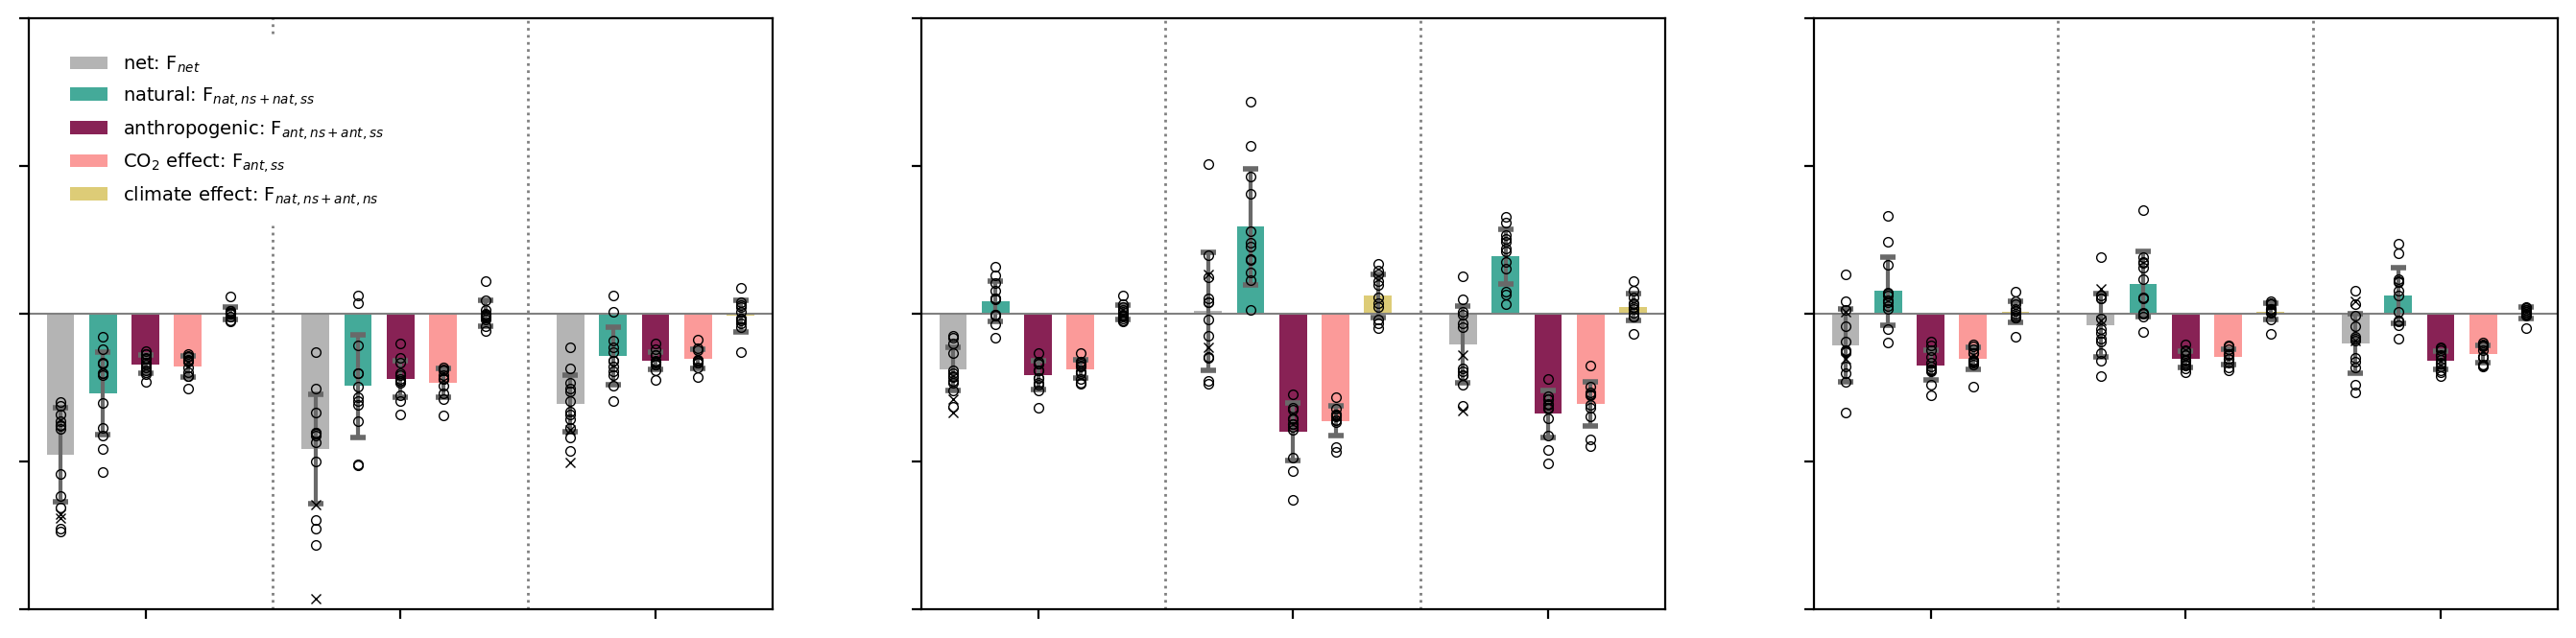

In [23]:
#----
# EPS
#
# plot for all nine regions
#----


def plot_bars_for_3_regions_eps(ax,ind_ss,add_to_models,\
                            flux_models_contemp_subareas,flux_models_nat_subareas,\
                            flux_models_anth_subareas,flux_models_anth_ss_subareas,\
                            flux_models_anth_ns_nat_ns_subareas,\
                           biome_area_river,biome_area_models_A,biome_area_models_D,\
                           biome_area_models_AD,biome_area_models_CB,biome_area_models_AC,subregions,\
                           panel_label,counter):
    
    factor2 = -1*365.*86400.*12.011/1e15
    factor  = 365.*86400.*12.011/1e15 # for river fluxes

    width = 0.65
    shift = 0.2
    fs_text = 12
    dpicnt  =200

    #blue for Fnet
    #green for Fnat (dark) and clim (light)
    #pinkish for anthropogenic (dark) and CO2 (light)
    # indian red 205,92,92
    
    color1 = (180./255.,180./255.,180./255.) # contemporary, grey
    color2 = (68./255.,170./255.,153./255.) # natural, teal
    #color2 = (178./255.,223./255.,138./255.) # natural, light green
    
    color3 = (136./255.,34./255.,85./255.) #(205./255.,92./255.,92./255.) # anthropogenic, dark red
    color4 = (251./255.,154./255.,153./255.) #(204./255.,102./255.,119./255.) # CO2 effect, light red
    color5 = (221./255.,204./255.,119./255.) # climate effect, sand

    alpha_contemp = 1.0
    alpha_nat     = 1.0#0.8
    alpha_anth    = 1.0#0.9#1.0#0.6
    alpha_co2     = 1.0#0.4
    alpha_clim    = 1.0#0.2

    color_dots = 'black'
    # markers for each model/data product
    circle_size=3.5
    edgewidth=0.5
    # whiskers for model/data spread
    whisker_properties = dict(lw=1.5, capsize=3, capthick=2,ecolor='dimgrey')

    unit = 'FCO$_{2}$ (Pg C yr$^{-1}$)'

    x_pos =np.asarray([1,2,3,4,5,\
        7,8,9,10,11,\
        13,14,15,16,17])
    x_pos = np.reshape(x_pos,[3,5])

    check_numbers = False # option to print some numbers

    label1 = 'net: F$_{net}$' #'contemporary FCO$_{2}$'
    label2 = 'natural: F$_{nat,ns+nat,ss}$' #'natural FCO$_{2}$'
    label3 = 'anthropogenic: F$_{ant,ns+ant,ss}$' #'anthropogenic FCO$_{2}$'
    label4 = 'CO$_{2}$ effect: F$_{ant,ss}$' #'CO2 effect on FCO$_{2}$'
    label5 = 'climate effect: F$_{nat,ns+ant,ns}$' #'climate effect on total FCO$_{2}$'
    
    ax.hlines(0,np.min(x_pos)-0.75,np.max(x_pos)+0.75,color='grey',linewidth=0.75)
    
    #-----
    # subregion 1
    #-----
    rr=ind_ss[0]
    print ('Plot ',subregions[rr])
    col=0
    #if check_numbers:
    #    print '######'
    #    print 'Contemporary flux in',subregions[rr]
    #    print '######'
    # contemporary
    alpha1 = alpha_contemp
    riv = factor*biome_area_river[rr]*add_to_models[rr]
    m_mean = np.mean(factor2*biome_area_models_A[ind_not_those,rr]*flux_models_contemp_subareas[ind_not_those,rr]+riv,axis=0)
    m_std  = np.std(factor2*biome_area_models_A[ind_not_those,rr]*flux_models_contemp_subareas[ind_not_those,rr],axis=0)
    #if check_numbers:
    #    print 'river flux:',riv
    #if check_numbers:
    #    print 'Multi-model mean:',m_mean
    ax.bar(x_pos[col,0],m_mean,width,color=color1,alpha=alpha1,yerr=m_std,\
                    error_kw=whisker_properties,label=label1)
    for mm in range(0,len(models_A)):
        #if check_numbers:
        #    ff = factor2*biome_area_models_A[mm,rr]*flux_models_contemp_subareas[mm,rr]
        #    reg = factor*biome_area_river[rr]* add_to_models[rr]
        #    print models_A[mm],ff+reg
        #    del ff,reg
        if models_A[mm] in ['FESOM_REcoM_HR','MOM6-COBALT2-Princeton','MOM6-Princeton']:
            ax.plot(x_pos[col,0],factor2*biome_area_models_A[mm,rr]*flux_models_contemp_subareas[mm,rr]+\
                factor*biome_area_river[rr]*add_to_models[rr],\
                 markeredgecolor=color_dots,marker='x',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None") 
        else:
            ax.plot(x_pos[col,0],factor2*biome_area_models_A[mm,rr]*flux_models_contemp_subareas[mm,rr]+\
                factor*biome_area_river[rr]*add_to_models[rr],\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None") 
    # nat
    alpha1 = alpha_nat
    m_mean = np.mean(factor2*biome_area_models_D[:,rr]*flux_models_nat_subareas[:,rr],axis=0)
    m_std  = np.std(factor2*biome_area_models_D[:,rr]*flux_models_nat_subareas[:,rr],axis=0)
    #if check_numbers:
    #    nat1 = m_mean
    #    print 'avg natural:',m_mean
    ax.bar(x_pos[col,1],m_mean,width,color=color2,alpha=alpha1,yerr=m_std,\
                    error_kw=whisker_properties,label=label2)
    for mm in range(0,len(models_D)):
        ax.plot(x_pos[col,1],factor2*biome_area_models_D[mm,rr]*flux_models_nat_subareas[mm,rr],\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None") 
    # anth
    alpha1 = alpha_anth
    m_mean = np.mean(factor2*biome_area_models_AD[:,rr]*flux_models_anth_subareas[:,rr],axis=0)
    m_std  = np.std(factor2*biome_area_models_AD[:,rr]*flux_models_anth_subareas[:,rr],axis=0)
    #if check_numbers:
    #    print 'avg anthropogenic:',m_mean
    #    print 'CHECK nat+anth+riv (should be equal to multi-model mean):',m_mean+nat1+riv
    ax.bar(x_pos[col,2],m_mean,width,color=color3,alpha=alpha1,yerr=m_std,\
                    error_kw=whisker_properties,label=label3)
    for mm in range(0,len(models_AD)):
        ax.plot(x_pos[col,2],factor2*biome_area_models_AD[mm,rr]*flux_models_anth_subareas[mm,rr],\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None")
    # CO2 effect only (anth,ss)
    alpha1 = alpha_co2
    m_mean = np.mean(factor2*biome_area_models_CB[:,rr]*flux_models_anth_ss_subareas[:,rr],axis=0)
    m_std  = np.std(factor2*biome_area_models_CB[:,rr]*flux_models_anth_ss_subareas[:,rr],axis=0)
    ax.bar(x_pos[col,3],m_mean,width,color=color4,alpha=alpha1,yerr=m_std,\
                    error_kw=whisker_properties,label=label4)
    for mm in range(0,len(models_CB)):
        ax.plot(x_pos[col,3],factor2*biome_area_models_CB[mm,rr]*flux_models_anth_ss_subareas[mm,rr],\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None")
    # climate
    alpha1 = alpha_clim
    m_mean = np.mean(factor2*biome_area_models_AC[:,rr]*flux_models_anth_ns_nat_ns_subareas[:,rr],axis=0)
    m_std  = np.std(factor2*biome_area_models_AC[:,rr]*flux_models_anth_ns_nat_ns_subareas[:,rr],axis=0)
    ax.bar(x_pos[col,4],m_mean,width,color=color5,alpha=alpha1,yerr=m_std,\
                    error_kw=whisker_properties,label=label5)
    for mm in range(0,len(models_AC)):
        ax.plot(x_pos[col,4],factor2*biome_area_models_AC[mm,rr]*flux_models_anth_ns_nat_ns_subareas[mm,rr],\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None")
    

    #-----
    # subregion2
    #-----
    rr=ind_ss[1]
    print ('Plot ',subregions[rr])
    col=1
    # contemporary
    alpha1 = alpha_contemp
    riv = factor*biome_area_river[rr]*add_to_models[rr]
    m_mean = np.mean(factor2*biome_area_models_A[ind_not_those,rr]*flux_models_contemp_subareas[ind_not_those,rr]+riv,axis=0)
    m_std  = np.std(factor2*biome_area_models_A[ind_not_those,rr]*flux_models_contemp_subareas[ind_not_those,rr],axis=0)
    ax.bar(x_pos[col,0],m_mean,width,color=color1,alpha=alpha1,yerr=m_std,\
                    error_kw=whisker_properties)#,label='contemporary FCO$_{2}$')
    for mm in range(0,len(models_A)):
        if models_A[mm] in ['FESOM_REcoM_HR','MOM6-COBALT2-Princeton','MOM6-Princeton']:
            ax.plot(x_pos[col,0],factor2*biome_area_models_A[mm,rr]*flux_models_contemp_subareas[mm,rr]+\
                factor*biome_area_river[rr]*add_to_models[rr],\
                 markeredgecolor=color_dots,marker='x',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None") 
        else:
            ax.plot(x_pos[col,0],factor2*biome_area_models_A[mm,rr]*flux_models_contemp_subareas[mm,rr]+\
                factor*biome_area_river[rr]*add_to_models[rr],\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None") 
    # nat
    alpha1 = alpha_nat
    m_mean = np.mean(factor2*biome_area_models_D[:,rr]*flux_models_nat_subareas[:,rr],axis=0)
    m_std  = np.std(factor2*biome_area_models_D[:,rr]*flux_models_nat_subareas[:,rr],axis=0)
    ax.bar(x_pos[col,1],m_mean,width,color=color2,alpha=alpha1,yerr=m_std,\
                    error_kw=whisker_properties)#,label='natural FCO$_{2}$')
    for mm in range(0,len(models_D)):
        ax.plot(x_pos[col,1],factor2*biome_area_models_D[mm,rr]*flux_models_nat_subareas[mm,rr],\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None") 
    # anth
    alpha1 = alpha_anth
    m_mean = np.mean(factor2*biome_area_models_AD[:,rr]*flux_models_anth_subareas[:,rr],axis=0)
    m_std  = np.std(factor2*biome_area_models_AD[:,rr]*flux_models_anth_subareas[:,rr],axis=0)
    ax.bar(x_pos[col,2],m_mean,width,color=color3,alpha=alpha1,yerr=m_std,\
                    error_kw=whisker_properties)#,label='anthropogenic FCO$_{2}$')
    for mm in range(0,len(models_AD)):
        ax.plot(x_pos[col,2],factor2*biome_area_models_AD[mm,rr]*flux_models_anth_subareas[mm,rr],\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None")
    # CO2 effect only (anth,ss)
    alpha1 = alpha_co2
    m_mean = np.mean(factor2*biome_area_models_CB[:,rr]*flux_models_anth_ss_subareas[:,rr],axis=0)
    m_std  = np.std(factor2*biome_area_models_CB[:,rr]*flux_models_anth_ss_subareas[:,rr],axis=0)
    ax.bar(x_pos[col,3],m_mean,width,color=color4,alpha=alpha1,yerr=m_std,\
                    error_kw=whisker_properties)#,label='CO2 effect on FCO$_{2}$')
    for mm in range(0,len(models_CB)):
        ax.plot(x_pos[col,3],factor2*biome_area_models_CB[mm,rr]*flux_models_anth_ss_subareas[mm,rr],\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None")
    # climate
    alpha1 = alpha_clim
    m_mean = np.mean(factor2*biome_area_models_AC[:,rr]*flux_models_anth_ns_nat_ns_subareas[:,rr],axis=0)
    m_std  = np.std(factor2*biome_area_models_AC[:,rr]*flux_models_anth_ns_nat_ns_subareas[:,rr],axis=0)
    ax.bar(x_pos[col,4],m_mean,width,color=color5,alpha=alpha1,yerr=m_std,\
                    error_kw=whisker_properties)#,label='climate effect on total FCO$_{2}$')
    for mm in range(0,len(models_AC)):
        ax.plot(x_pos[col,4],factor2*biome_area_models_AC[mm,rr]*flux_models_anth_ns_nat_ns_subareas[mm,rr],\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None")
    
    #-----
    # subregion3
    #-----
    rr=ind_ss[2]
    print ('Plot ',subregions[rr])
    col=2
    # contemporary
    alpha1 = alpha_contemp
    riv = factor*biome_area_river[rr]*add_to_models[rr]
    m_mean = np.mean(factor2*biome_area_models_A[ind_not_those,rr]*flux_models_contemp_subareas[ind_not_those,rr]+riv,axis=0)
    m_std  = np.std(factor2*biome_area_models_A[ind_not_those,rr]*flux_models_contemp_subareas[ind_not_those,rr],axis=0)
    ax.bar(x_pos[col,0],m_mean,width,color=color1,alpha=alpha1,yerr=m_std,\
                    error_kw=whisker_properties)#,label='contemporary FCO$_{2}$')
    for mm in range(0,len(models_A)):
        if models_A[mm] in ['FESOM_REcoM_HR','MOM6-COBALT2-Princeton','MOM6-Princeton']:
            ax.plot(x_pos[col,0],factor2*biome_area_models_A[mm,rr]*flux_models_contemp_subareas[mm,rr]+\
                factor*biome_area_river[rr]*add_to_models[rr],\
                 markeredgecolor=color_dots,marker='x',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None") 
        else:
            ax.plot(x_pos[col,0],factor2*biome_area_models_A[mm,rr]*flux_models_contemp_subareas[mm,rr]+\
                factor*biome_area_river[rr]*add_to_models[rr],\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None") 
    # nat
    alpha1 = alpha_nat
    m_mean = np.mean(factor2*biome_area_models_D[:,rr]*flux_models_nat_subareas[:,rr],axis=0)
    m_std  = np.std(factor2*biome_area_models_D[:,rr]*flux_models_nat_subareas[:,rr],axis=0)
    ax.bar(x_pos[col,1],m_mean,width,color=color2,alpha=alpha1,yerr=m_std,\
                    error_kw=whisker_properties)#,label='natural FCO$_{2}$')
    for mm in range(0,len(models_D)):
        ax.plot(x_pos[col,1],factor2*biome_area_models_D[mm,rr]*flux_models_nat_subareas[mm,rr],\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None") 
    # anth
    alpha1 = alpha_anth
    m_mean = np.mean(factor2*biome_area_models_AD[:,rr]*flux_models_anth_subareas[:,rr],axis=0)
    m_std  = np.std(factor2*biome_area_models_AD[:,rr]*flux_models_anth_subareas[:,rr],axis=0)
    ax.bar(x_pos[col,2],m_mean,width,color=color3,alpha=alpha1,yerr=m_std,\
                    error_kw=whisker_properties)#,label='anthropogenic FCO$_{2}$')
    for mm in range(0,len(models_AD)):
        ax.plot(x_pos[col,2],factor2*biome_area_models_AD[mm,rr]*flux_models_anth_subareas[mm,rr],\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None")
    # CO2 effect only (anth,ss)
    alpha1 = alpha_co2
    m_mean = np.mean(factor2*biome_area_models_CB[:,rr]*flux_models_anth_ss_subareas[:,rr],axis=0)
    m_std  = np.std(factor2*biome_area_models_CB[:,rr]*flux_models_anth_ss_subareas[:,rr],axis=0)
    ax.bar(x_pos[col,3],m_mean,width,color=color4,alpha=alpha1,yerr=m_std,\
                    error_kw=whisker_properties)#,label='CO2 effect on FCO$_{2}$')
    for mm in range(0,len(models_CB)):
        ax.plot(x_pos[col,3],factor2*biome_area_models_CB[mm,rr]*flux_models_anth_ss_subareas[mm,rr],\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None")
    # climate
    alpha1 = alpha_clim
    m_mean = np.mean(factor2*biome_area_models_AC[:,rr]*flux_models_anth_ns_nat_ns_subareas[:,rr],axis=0)
    m_std  = np.std(factor2*biome_area_models_AC[:,rr]*flux_models_anth_ns_nat_ns_subareas[:,rr],axis=0)
    ax.bar(x_pos[col,4],m_mean,width,color=color5,alpha=alpha1,yerr=m_std,\
                    error_kw=whisker_properties)#,label='climate effect on total FCO$_{2}$')
    for mm in range(0,len(models_AC)):
        ax.plot(x_pos[col,4],factor2*biome_area_models_AC[mm,rr]*flux_models_anth_ns_nat_ns_subareas[mm,rr],\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None")
    
    if counter>0:
        ax.legend(loc='right',bbox_to_anchor=(0.5, 0.81), \
                  ncol=1,markerfirst=True,fancybox=False, \
                   frameon=False,shadow=False,prop={'size': 7}) 
        #ax.legend(loc='right',bbox_to_anchor=(1.0, 0.17), \
        #          ncol=1,markerfirst=False,fancybox=False, \
        #           frameon=False,shadow=False,prop={'size': 6}) 

    #if counter>0:
    #    ax.annotate(panel_label,xy=(-0.18,0.98), xycoords='axes fraction',fontsize=fs_text+1,fontweight='bold')
    #else:
    #    ax.annotate(panel_label,xy=(-0.16,0.98), xycoords='axes fraction',fontsize=fs_text+1,fontweight='bold') 
    
    ax.set_xlim((np.min(x_pos)-0.75,np.max(x_pos)+0.75))
    ax.set_xticks([x_pos[0,2],x_pos[1,2],x_pos[2,2]])
    ax.set_xticklabels([],\
                       fontweight='bold')
    ax.set_ylim((-0.4,0.4))
    ylim1,ylim2 = ax.get_ylim()
    
    if counter>0:
        ax.set_yticks([-0.4,-0.2,0,0.2,0.4])
        ax.set_yticklabels([])
        #ax.set_ylabel(unit,fontsize=fs_text)
        ax.vlines(6,ylim1,0.12,linestyle=':',color='grey',linewidth=1.0)
        ax.vlines(6,0.38,0.4,linestyle=':',color='grey',linewidth=1.0)
        ax.vlines(12,ylim1,ylim2,linestyle=':',color='grey',linewidth=1.0)
    else:
        ax.set_yticks([-0.4,-0.2,0,0.2,0.4])
        #ax.set_yticklabels([])
        ax.set_yticklabels([])
        #ax.set_ylabel(unit,fontsize=fs_text)
        ax.vlines(6,ylim1,ylim2,linestyle=':',color='grey',linewidth=1.0)
        ax.vlines(12,ylim1,ylim2,linestyle=':',color='grey',linewidth=1.0)
        
    for label in ax.yaxis.get_majorticklabels():
            label.set_size(fs_text-2)

    for label in ax.xaxis.get_majorticklabels():
            label.set_size(fs_text-2)
            
    


fig, axs = plt.subplots(1,3,figsize=(17,4), dpi=dpicnt,\
                            gridspec_kw={'width_ratios': [1,1,1],\
                                         'height_ratios': [1]})

ax1 = plt.subplot2grid((1,3), (0,0))
ax2 = plt.subplot2grid((1,3), (0,1))
ax3 = plt.subplot2grid((1,3), (0,2))

ax=ax1
plot_bars_for_3_regions_eps(ax,[0,1,2],add_to_models,\
                            flux_models_contemp_subareas,flux_models_nat_subareas,\
                            flux_models_anth_subareas,flux_models_anth_ss_subareas,\
                            flux_models_anth_ns_nat_ns_subareas,\
                           biome_area_river,biome_area_models_A,biome_area_models_D,\
                           biome_area_models_AD,biome_area_models_CB,biome_area_models_AC,subregions,'a)',1)

ax=ax2
#ax.set_axis_off()
plot_bars_for_3_regions_eps(ax,[3,4,5],add_to_models,\
                            flux_models_contemp_subareas,flux_models_nat_subareas,\
                            flux_models_anth_subareas,flux_models_anth_ss_subareas,\
                            flux_models_anth_ns_nat_ns_subareas,\
                           biome_area_river,biome_area_models_A,biome_area_models_D,\
                           biome_area_models_AD,biome_area_models_CB,biome_area_models_AC,subregions,'b)',0)

ax=ax3
#ax.set_axis_off() 
plot_bars_for_3_regions_eps(ax,[6,7,8],add_to_models,\
                            flux_models_contemp_subareas,flux_models_nat_subareas,\
                            flux_models_anth_subareas,flux_models_anth_ss_subareas,\
                            flux_models_anth_ns_nat_ns_subareas,\
                           biome_area_river,biome_area_models_A,biome_area_models_D,\
                           biome_area_models_AD,biome_area_models_CB,biome_area_models_AC,subregions,'c)',0)
        
filename1 = 'fig3_bar_plot_CO2_flux_anth_nat_climate_'+str(year1)+'_'+str(year2)+'_9regions'
plt.savefig(save_to_dir+filename1+'.eps',dpi = dpicnt, bbox_inches='tight',format='eps')

plt.show()



In [20]:
#----
# print some numbers!
#----

print_numbers = False

if print_numbers:
    #----
    # print multi-model averages
    #----
    filename_numbers = 'Fig3_numbers_multi_model_averages.txt'
    f = open(save_to_dir+filename_numbers, "a")
    print('NOTE: FESOM_HR and MOM6 are not included in multi-model mean & std of F_net',file=f)

    for rr in range(len(subregions)-1, -1, -1):
        add_rivers = factor*biome_area_river[rr]*add_to_models[rr]
        # contemporary: simA+riv
        m_mean_cont = np.mean(factor2*biome_area_models_A[ind_not_those,rr]*flux_models_contemp_subareas[ind_not_those,rr]+add_rivers,axis=0)
        m_std_cont  = np.std(factor2*biome_area_models_A[ind_not_those,rr]*flux_models_contemp_subareas[ind_not_those,rr],axis=0)
        # natural: simD
        m_mean_nat = np.mean(factor2*biome_area_models_D[:,rr]*flux_models_nat_subareas[:,rr],axis=0)
        m_std_nat  = np.std(factor2*biome_area_models_D[:,rr]*flux_models_nat_subareas[:,rr],axis=0)
        # anthropogenic: simA-simD
        m_mean_ant = np.mean(factor2*biome_area_models_AD[:,rr]*flux_models_anth_subareas[:,rr],axis=0)
        m_std_ant  = np.std(factor2*biome_area_models_AD[:,rr]*flux_models_anth_subareas[:,rr],axis=0)
        # CO2 effect: simC-simB
        m_mean_co2 = np.mean(factor2*biome_area_models_CB[:,rr]*flux_models_anth_ss_subareas[:,rr],axis=0)
        m_std_co2  = np.std(factor2*biome_area_models_CB[:,rr]*flux_models_anth_ss_subareas[:,rr],axis=0)
        # climate effect: simA-simC
        m_mean_clim = np.mean(factor2*biome_area_models_AC[:,rr]*flux_models_anth_ns_nat_ns_subareas[:,rr],axis=0)
        m_std_clim  = np.std(factor2*biome_area_models_AC[:,rr]*flux_models_anth_ns_nat_ns_subareas[:,rr],axis=0)

        print('##########', file=f)
        print('Region '+subregions[rr]+':', file=f)
        print('River adjustment:'+str(add_rivers),file=f)
        print('----',file=f)
        print('Contemporary, i.e. simA+river flux',file=f)
        print ('multi-model mean:',m_mean_cont, file=f)
        print ('multi-model std:',m_std_cont, file=f)
        print('----',file=f)
        print('Natural (nat,ns+nat,ss), i.e. simD',file=f)
        print ('multi-model mean:',m_mean_nat, file=f)
        print ('multi-model std:',m_std_nat, file=f)
        print('----',file=f)
        print('Anthropogenic (anth,ns+anth,ss), i.e. simA-simD',file=f)
        print ('multi-model mean:',m_mean_ant, file=f)
        print ('multi-model std:',m_std_ant, file=f)
        print('----',file=f)
        print('CO2 effect (anth,ss), i.e. simC-simB',file=f)
        print ('multi-model mean:',m_mean_co2, file=f)
        print ('multi-model std:',m_std_co2, file=f)
        print('----',file=f)
        print('Climate effect (nat,ns+anth,ns), i.e. simA-simC',file=f)
        print ('multi-model mean:',m_mean_clim, file=f)
        print ('multi-model std:',m_std_clim, file=f)
        print('----',file=f)
        print ('##########', file=f)
        print ('', file=f)

    f.close()

    print('done')
    

In [21]:
#-----
# print individual models
#------

if print_numbers:
    #---
    # contemporary
    #---
    filename_numbers = 'Fig3_numbers_all_models_contemporary.txt'
    f = open(save_to_dir+filename_numbers, "a")
    print('contemporary: simA+riv',file=f)

    for rr in range(len(subregions)-1, -1, -1):
        add_rivers = factor*biome_area_river[rr]*add_to_models[rr]
        # contemporary: simA+riv
        print('##########', file=f)
        print('Region '+subregions[rr]+':', file=f)
        print('River adjustment:'+str(add_rivers),file=f)
        for mm in range(0,len(models_A)):
            print (models_A[mm],factor2*biome_area_models_A[mm,rr]*flux_models_contemp_subareas[mm,rr]+\
                factor*biome_area_river[rr]*add_to_models[rr], file=f)
        print ('##########', file=f)
        print ('', file=f)
    f.close()

    #---
    # natural
    #---
    filename_numbers = 'Fig3_numbers_all_models_natural.txt'
    f = open(save_to_dir+filename_numbers, "a")
    print('Natural (nat,ns+nat,ss), i.e. simD',file=f)

    for rr in range(len(subregions)-1, -1, -1):
        print('##########', file=f)
        print('Region '+subregions[rr]+':', file=f)
        for mm in range(0,len(models_D)):
            print (models_D[mm],factor2*biome_area_models_D[mm,rr]*flux_models_nat_subareas[mm,rr], file=f)
        print ('##########', file=f)
        print ('', file=f)
    f.close()

    #---
    # anthrpogenic
    #---
    filename_numbers = 'Fig3_numbers_all_models_anthropogenic.txt'
    f = open(save_to_dir+filename_numbers, "a")
    print('Anthropogenic (anth,ns+anth,ss), i.e. simA-simD',file=f)

    for rr in range(len(subregions)-1, -1, -1):
        print('##########', file=f)
        print('Region '+subregions[rr]+':', file=f)
        for mm in range(0,len(models_AD)):
            print (models_AD[mm],factor2*biome_area_models_AD[mm,rr]*flux_models_anth_subareas[mm,rr], file=f)
        print ('##########', file=f)
        print ('', file=f)
    f.close()

    #---
    # CO2 effect
    #---
    filename_numbers = 'Fig3_numbers_all_models_CO2_effect.txt'
    f = open(save_to_dir+filename_numbers, "a")
    print('CO2 effect (anth,ss), i.e. simC-simB',file=f)

    for rr in range(len(subregions)-1, -1, -1):
        print('##########', file=f)
        print('Region '+subregions[rr]+':', file=f)
        for mm in range(0,len(models_CB)):
            print (models_CB[mm],factor2*biome_area_models_CB[mm,rr]*flux_models_anth_ss_subareas[mm,rr], file=f)
        print ('##########', file=f)
        print ('', file=f)
    f.close()

    #---
    # climate effect
    #---
    filename_numbers = 'Fig3_numbers_all_models_climate_effect.txt'
    f = open(save_to_dir+filename_numbers, "a")
    print('Climate effect (nat,ns+anth,ns), i.e. simA-simC',file=f)

    for rr in range(len(subregions)-1, -1, -1):
        print('##########', file=f)
        print('Region '+subregions[rr]+':', file=f)
        for mm in range(0,len(models_AC)):
            print (models_AC[mm],factor2*biome_area_models_AC[mm,rr]*flux_models_anth_ns_nat_ns_subareas[mm,rr], file=f)
        print ('##########', file=f)
        print ('', file=f)
    f.close()

    print('done')

In [24]:
print(save_to_dir)

/global/cfs/cdirs/m4003/cnissen/Plots/RECCAPv2_SO_Paper/Fig3/
